In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
from sklearn.impute import KNNImputer
import scipy.stats as ss
import warnings
from scipy.stats import chi2_contingency
import sys
import os

pd.set_option('display.max_columns', 5000)
pd.set_option('display.max_rows', 5000)

In [2]:
sys.path.append(os.path.abspath('../src'))
import f_aux

Cargo todas las librerías que voy a necesitar así como descargo las que no había utilizado hasta ahora (!pip install scikit-learn) y que voy a utilizar en este cuaderno. A continuación añado las funciones que nos han dado los profesores y que se van a utilizar a lo largo de este cuaderno

In [ ]:
def dame_variables_categoricas(dataset=None):
    '''
    ----------------------------------------------------------------------------------------------------------
    Function dame_variables_categoricas:
    ----------------------------------------------------------------------------------------------------------
       -description: Function that receives a dataset and returns a list with the names of the 
        categorical variables.
        -Inputs: 
            -- dataset: Pandas dataframe containing the data.
        -Return:
        -- list_categorical_variables: list with the names of the categorical variables in the 
        input dataset that have fewer than 100 unique values.
        -- 1: execution is incorrect.
    '''
    if dataset is None:
        print(u'\There are no arguments to pass to the function.')
        return 1
    list_categorical_variables = []
    other = []
    for i in dataset.columns:
        if (dataset[i].dtype != float) & (dataset[i].dtype != int):
            unicos = int(len(np.unique(dataset[i].dropna(axis=0, how='all'))))
            if unicos < 100:
                list_categorical_variables.append(i)
            else:
                other.append(i)
    num_categorical = len(list_categorical_variables)
    
    return list_categorical_variables, other, num_categorical

def dame_variables_continuas(dataset=None):
    '''
    ----------------------------------------------------------------------------------------------------------
    Function dame_variables_continuas:
    ----------------------------------------------------------------------------------------------------------
       -description: Function that receives a dataset and returns a list with the names of the 
        continuous variables.
        -Inputs: 
            -- dataset: Pandas dataframe containing the data.
        -Return:
        -- lista_continuous_variables: list with the names of the continuous variables in the 
        input dataset that have fewer than 100 unique values.
        -- 1: execution is incorrect.
    '''
    if dataset is None:
        print(u'\There are no arguments to pass to the function.')
        return 1
    
    list_continuous_variables = []
    other = []
    
    for i in dataset.columns:
        if dataset[i].dtype in [float, int]:
            unicos = dataset[i].nunique()
            if unicos >= 10:
                lista_continuous_variables.append(i)
            else:
                other.append(i)
    
    num_continuas = len(list_continuous_variables)
    
    return list_continuous_variables, other

def cramers_v(confusion_matrix):
    """ 
    calculate Cramers V statistic for categorial-categorial association.
    uses correction from Bergsma and Wicher,
    Journal of the Korean Statistical Society 42 (2013): 323-328
    
    confusion_matrix: tabla creada con pd.crosstab()
    
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

He creado las siguientes funciones para en un futuro utilizarlas en la creación de gráficos divididos por variables categóricas (plot_categorical_feature) y variables continuas (plot_continuous_feature) ya que la función proporcionada en el HTML no terminaba de cargar los gráficos y tras mucho tiempo (hasta 1h 30m corriendo el código) y por consejo de los docentes dividi la creación de gráficos en gráficos para las variables continuas y gráficos para las variables categóricas.

In [ ]:
def plot_categorical_feature(df, col_name, target):
    """
    Visualize a categorical variable with and without faceting on the target variable.
    - df: DataFrame containing the data
    - col_name: Name of the categorical variable to plot
    - target: The target variable for faceting
    """
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
    
    count_null = df[col_name].isnull().sum()
    
    # Category count display
    sns.countplot(x=df[col_name], order=sorted(df[col_name].dropna().unique()), color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(col_name)
    ax1.set_ylabel('Count')
    ax1.set_title(f'{col_name} - Número de nulos: {count_null}')
    plt.xticks(rotation=90)

    # Visualization of the distribution of the target variable according to the categorical variable.
    data = df.groupby(col_name)[target].value_counts(normalize=True).to_frame('proportion').reset_index()
    data.columns = [col_name, target, 'proportion']
    
    sns.barplot(x=col_name, y='proportion', hue=target, data=data, saturation=1, ax=ax2)
    ax2.set_ylabel(f'{target} fraction')
    ax2.set_title(f'{target} distribution by {col_name}')
    ax2.set_xlabel(col_name)
    plt.xticks(rotation=90)

    plt.tight_layout()
    
def plot_continuous_feature(df, col_name, target):
    """
    Visualize a continuous variable with and without faceting on the target variable.
    - df: DataFrame containing the data
    - col_name: Name of the continuous variable to plot
    - target: The target variable for faceting
    """
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
    
    count_null = df[col_name].isnull().sum()

    # Histogram display
    sns.histplot(df.loc[df[col_name].notnull(), col_name], kde=False, ax=ax1)
    ax1.set_xlabel(col_name)
    ax1.set_ylabel('Count')
    ax1.set_title(f'{col_name} - Número de nulos: {count_null}')

    # Boxplot display for the continuous variable and target variable
    sns.boxplot(x=col_name, y=target, data=df, ax=ax2, hue=target, palette="Set2")  # Hue and palette are added
    ax2.set_ylabel('')
    ax2.set_title(f'{col_name} by {target}')
    ax2.set_xlabel(col_name)
    
    plt.tight_layout()

    """
    Calculates correlations between continuous variables and the target variable.
    
    :param df: DataFrame containing the data.
    :param target: Name of the target column (e.g., 'TARGET').
    :param list_var_cont: List of names of the continuous variables.
    
    :return: DataFrame with the correlations of the continuous variables with the target variable.
    """
    # Create a dictionary to store correlations
    correlations= {}
    
    # We go through each continuous variable in the list.
    for var in list_var_cont:
        # We calculate the Pearson correlation between the variable and the objective.
        correlacion = df[var].corr(df[target])
        # We store the correlation in the dictionary.
        correlations[var] = correlation
    
    # We convert the dictionary into a DataFrame for better visualization.
    correlations_df = pd.DataFrame(list(correlations.items()), columns=['variable', 'correlation'])
    
    # We order the DataFrame from highest to lowest according to the column 'Correlation'.
    correlations_df = correlations_df.sort_values(by='correlation', ascending=False)
    
    return correlations_df

Cargo todas las librerías que voy a necesitar así como descargo las que no había utilizado hasta ahora (!pip install scikit-learn) y que voy a utilizar en este cuaderno. A continuación añado las funciones que nos han dado los profesores y que se van a utilizar a lo largo de este cuaderno

Cargamos el dataset del notebook anterior a través del .csv creado al final de notebook 01. Al igual que el anterior dataframe, se utiliza una ruta relativa para la lectura de dataset en cualquier dispositivo que descargue el .zip. Además, se carga obviando una columna creada al exportarlo llamada '^Unnamed:' y se comprueba que tiene las dimensiones del que habiamos guardado.

In [ ]:
pd_loan = pd.read_csv("../data/pd_data_initial_preprocessing.csv")
pd_loan = pd_loan.loc[:, ~pd_loan.columns.str.contains('^Unnamed:')] #A column called 'Unnamed' had been created, possibly as a result of exporting it to .csv at the end of the previous notebook, so I deleted it.
pd_loan.shape

(307511, 122)

Comprobamos que tenemos las mismas columnas/variables:

In [6]:
pd_loan.columns

Index(['COMMONAREA_MEDI', 'COMMONAREA_AVG', 'COMMONAREA_MODE',
       'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAPARTMENTS_AVG',
       'NONLIVINGAPARTMENTS_MEDI', 'FONDKAPREMONT_MODE',
       'LIVINGAPARTMENTS_MODE', 'LIVINGAPARTMENTS_AVG',
       'LIVINGAPARTMENTS_MEDI',
       ...
       'DAYS_ID_PUBLISH', 'DAYS_REGISTRATION', 'DAYS_EMPLOYED', 'DAYS_BIRTH',
       'REGION_POPULATION_RELATIVE', 'NAME_HOUSING_TYPE', 'NAME_FAMILY_STATUS',
       'NAME_EDUCATION_TYPE', 'NAME_INCOME_TYPE', 'SK_ID_CURR'],
      dtype='object', length=122)

Utilizamos las dos funciones que nos devuelven la categoría de las variables y creamos las listas en este notebook.

In [7]:
list_var_cat, other_cat = dame_variables_categoricas(dataset=pd_loan)
pd_loan[list_var_cat] = pd_loan[list_var_cat].astype("category")
list_var_cont, other_cont = dame_variables_continuas(dataset=pd_loan)
pd_loan.dtypes

COMMONAREA_MEDI                  float64
COMMONAREA_AVG                   float64
COMMONAREA_MODE                  float64
NONLIVINGAPARTMENTS_MODE         float64
NONLIVINGAPARTMENTS_AVG          float64
NONLIVINGAPARTMENTS_MEDI         float64
FONDKAPREMONT_MODE              category
LIVINGAPARTMENTS_MODE            float64
LIVINGAPARTMENTS_AVG             float64
LIVINGAPARTMENTS_MEDI            float64
FLOORSMIN_AVG                    float64
FLOORSMIN_MODE                   float64
FLOORSMIN_MEDI                   float64
YEARS_BUILD_MEDI                 float64
YEARS_BUILD_MODE                 float64
YEARS_BUILD_AVG                  float64
OWN_CAR_AGE                      float64
LANDAREA_MEDI                    float64
LANDAREA_MODE                    float64
LANDAREA_AVG                     float64
BASEMENTAREA_MEDI                float64
BASEMENTAREA_AVG                 float64
BASEMENTAREA_MODE                float64
EXT_SOURCE_1                     float64
NONLIVINGAREA_MO

Vemos que variables obtenemos como categóricas

In [8]:
print(list_var_cat)
len(list_var_cat)

['FONDKAPREMONT_MODE', 'WALLSMATERIAL_MODE', 'HOUSETYPE_MODE', 'EMERGENCYSTATE_MODE', 'OCCUPATION_TYPE', 'NAME_TYPE_SUITE', 'CNT_CHILDREN', 'FLAG_DOCUMENT_8', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_21', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_OWN_REALTY', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_12', 'FLAG_PHONE', 'LIVE_CITY_NOT_WORK_CITY', 'REG_CITY_NOT_WORK_CITY', 'TARGET', 'REG_CITY_NOT_LIVE_CITY', 'LIVE_REGION_NOT_WORK_REGION', 'REG_REGION_NOT_WORK_REGION', 'REG_REGION_NOT_LIVE_REGION', 'HOUR_APPR_PROCESS_START', 'WEEKDAY_APPR_PROCESS_START', 'REGION_RATING_CLIENT_W_CITY', 'REGION_RATING_CLIENT', 'FLAG_EMAIL', 'FLAG_CONT_MOBILE', 'ORGANIZATION_TYPE', 'FLAG_WORK_PHONE', 'FLAG_EMP_PHONE'

53

Vemos que variables obtenemos como continuas

In [9]:
print(list_var_cont)
len(list_var_cont)

['COMMONAREA_MEDI', 'COMMONAREA_AVG', 'COMMONAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAPARTMENTS_MEDI', 'LIVINGAPARTMENTS_MODE', 'LIVINGAPARTMENTS_AVG', 'LIVINGAPARTMENTS_MEDI', 'FLOORSMIN_AVG', 'FLOORSMIN_MODE', 'FLOORSMIN_MEDI', 'YEARS_BUILD_MEDI', 'YEARS_BUILD_MODE', 'YEARS_BUILD_AVG', 'OWN_CAR_AGE', 'LANDAREA_MEDI', 'LANDAREA_MODE', 'LANDAREA_AVG', 'BASEMENTAREA_MEDI', 'BASEMENTAREA_AVG', 'BASEMENTAREA_MODE', 'EXT_SOURCE_1', 'NONLIVINGAREA_MODE', 'NONLIVINGAREA_AVG', 'NONLIVINGAREA_MEDI', 'ELEVATORS_MEDI', 'ELEVATORS_AVG', 'ELEVATORS_MODE', 'APARTMENTS_MEDI', 'APARTMENTS_AVG', 'APARTMENTS_MODE', 'ENTRANCES_MEDI', 'ENTRANCES_AVG', 'ENTRANCES_MODE', 'LIVINGAREA_AVG', 'LIVINGAREA_MODE', 'LIVINGAREA_MEDI', 'FLOORSMAX_MODE', 'FLOORSMAX_MEDI', 'FLOORSMAX_AVG', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BEGINEXPLUATATION_AVG', 'TOTALAREA_MODE', 'EXT_SOURCE_3', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ

61

In [10]:
print(other_cat+other_cont)

['DAYS_ID_PUBLISH', 'DAYS_EMPLOYED', 'DAYS_BIRTH', 'SK_ID_CURR', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'DEF_60_CNT_SOCIAL_CIRCLE']


En total tenemos 122 variables, 53 categóricas, 61 continuas y 8 'other' al igual que en el dataset del notebook anterior

Graficamos de nuevo la distribución de la variable objetivo entre aquellos que tienen dificultades para pagar (1) y aquellos que no (0)

In [ ]:
pd_plot_loan_status = pd_loan['TARGET']\
        .value_counts(normalize=True)\
        .mul(100).rename('percent').reset_index()

# Calculate TARGET counts
pd_plot_loan_status_count = pd_loan['TARGET'].value_counts().reset_index()

# Make the merge
pd_plot_loan_status_pc = pd.merge(pd_plot_loan_status, 
                                  pd_plot_loan_status_count, 
                                  on='TARGET', how='inner')

# Plot
fig = px.histogram(pd_plot_loan_status_pc, x="TARGET", y="percent")
fig.show()

Realizamos la división del dataset en train, el cual estara conformado por el 80% de los datos, y test, conformado por el 20% restante, además se utiliza la sintaxis "stratify=pd_loan['TARGET']" para que divida proporcionalmente las muestras para obtener el mismo % de 1 y 0 tanto en train como en test

In [12]:
from sklearn.model_selection import train_test_split
x_pd_loan, x_pd_loan_test, y_pd_loan, y_pd_loan_test = train_test_split(pd_loan.drop('TARGET',axis=1), 
                                                                     pd_loan['TARGET'], 
                                                                     stratify=pd_loan['TARGET'], 
                                                                     test_size=0.2)
pd_loan_train = pd.concat([x_pd_loan, y_pd_loan],axis=1)
pd_loan_test = pd.concat([x_pd_loan_test, y_pd_loan_test],axis=1)

Comprobamos que ha funcionado el stratify, y tanto el train como el test tienen la misma proporcion de 0 y 1 (0.919 para los 0 y 0.80 para los 1)

In [13]:
print('== Train\n', pd_loan_train['TARGET'].value_counts(normalize=True))
print('== Test\n', pd_loan_test['TARGET'].value_counts(normalize=True))

== Train
 TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64
== Test
 TARGET
0    0.919272
1    0.080728
Name: proportion, dtype: float64


In [14]:
pd_series_null_columns = pd_loan_train.isnull().sum().sort_values(ascending=False)
pd_series_null_rows = pd_loan_train.isnull().sum(axis=1).sort_values(ascending=False)
print(pd_series_null_columns.shape, pd_series_null_rows.shape)

(122,) (246008,)


In [ ]:
pd_null_columns = pd.DataFrame(pd_series_null_columns, columns=['columns_nulls'])     
pd_null_rows = pd.DataFrame(pd_series_null_rows, columns=['row_nulls'])  
pd_null_rows['target'] = pd_loan['TARGET'].copy()
pd_null_columns['columns_percentage'] = pd_null_columns['columns_nulls']/pd_loan_train.shape[0]
pd_null_rows['rows_percentage']= pd_null_rows['row_nulls']/pd_loan_train.shape[1]

El nuevo dataset de 'train' tiene una dimensión de 246008 filas para las 122 variables del dataset y de nuevo, a continuación volvemos a ver el porcentaje de nulos que existe por cada columna del dataframe.

In [ ]:
pd_null_columns

nulos_columnas  porcentaje_columnas
COMMONAREA_MEDI                       171972             0.699050
COMMONAREA_MODE                       171972             0.699050
COMMONAREA_AVG                        171972             0.699050
NONLIVINGAPARTMENTS_MODE              170909             0.694729
NONLIVINGAPARTMENTS_MEDI              170909             0.694729
NONLIVINGAPARTMENTS_AVG               170909             0.694729
FONDKAPREMONT_MODE                    168327             0.684234
LIVINGAPARTMENTS_AVG                  168277             0.684031
LIVINGAPARTMENTS_MEDI                 168277             0.684031
LIVINGAPARTMENTS_MODE                 168277             0.684031
FLOORSMIN_AVG                         166993             0.678811
FLOORSMIN_MODE                        166993             0.678811
FLOORSMIN_MEDI                        166993             0.678811
YEARS_BUILD_MODE                      163682             0.665352
YEARS_BUILD_AVG                       163682             0.665352
YEARS_BUILD_MEDI                      163682             0.665352
OWN_CAR_AGE                           162223             0.659422
LANDAREA_MODE                         146053             0.593692
LANDAREA_AVG                          146053             0.593692
LANDAREA_MEDI                         146053             0.593692
BASEMENTAREA_MEDI                     143994             0.585322
BASEMENTAREA_AVG                      143994             0.585322
BASEMENTAREA_MODE                     143994             0.585322
EXT_SOURCE_1                          138885             0.564555
NONLIVINGAREA_MODE                    135759             0.551848
NONLIVINGAREA_AVG                     135759             0.551848
NONLIVINGAREA_MEDI                    135759             0.551848
ELEVATORS_AVG                         131138             0.533064
ELEVATORS_MODE                        131138             0.533064
ELEVATORS_MEDI                        131138             0.533064
WALLSMATERIAL_MODE                    125093             0.508492
APARTMENTS_MEDI                       124856             0.507528
APARTMENTS_AVG                        124856             0.507528
APARTMENTS_MODE                       124856             0.507528
ENTRANCES_MEDI                        123897             0.503630
ENTRANCES_AVG                         123897             0.503630
ENTRANCES_MODE                        123897             0.503630
LIVINGAREA_AVG                        123502             0.502024
LIVINGAREA_MODE                       123502             0.502024
LIVINGAREA_MEDI                       123502             0.502024
HOUSETYPE_MODE                        123479             0.501931
FLOORSMAX_MODE                        122449             0.497744
FLOORSMAX_MEDI                        122449             0.497744
FLOORSMAX_AVG                         122449             0.497744
YEARS_BEGINEXPLUATATION_AVG           120063             0.488045
YEARS_BEGINEXPLUATATION_MODE          120063             0.488045
YEARS_BEGINEXPLUATATION_MEDI          120063             0.488045
TOTALAREA_MODE                        118781             0.482834
EMERGENCYSTATE_MODE                   116618             0.474041
OCCUPATION_TYPE                        77177             0.313717
EXT_SOURCE_3                           48916             0.198839
AMT_REQ_CREDIT_BUREAU_HOUR             33287             0.135309
AMT_REQ_CREDIT_BUREAU_DAY              33287             0.135309
AMT_REQ_CREDIT_BUREAU_WEEK             33287             0.135309
AMT_REQ_CREDIT_BUREAU_MON              33287             0.135309
AMT_REQ_CREDIT_BUREAU_QRT              33287             0.135309
AMT_REQ_CREDIT_BUREAU_YEAR             33287             0.135309
NAME_TYPE_SUITE                         1035             0.004207
OBS_60_CNT_SOCIAL_CIRCLE                 819             0.003329
DEF_60_CNT_SOCIAL_CIRCLE                 819             0.003329
DEF_

In [ ]:
pd_null_rows.head()

nulos_filas target  porcentaje_filas
150206           61      0               0.5
185713           61      0               0.5
269492           61      0               0.5
269786           61      0               0.5
116937           61      0               0.5

In [18]:
f_aux.dame_variables_categoricas(pd_loan_train)


(['FONDKAPREMONT_MODE',
  'WALLSMATERIAL_MODE',
  'HOUSETYPE_MODE',
  'EMERGENCYSTATE_MODE',
  'OCCUPATION_TYPE',
  'NAME_TYPE_SUITE',
  'CNT_CHILDREN',
  'FLAG_DOCUMENT_8',
  'NAME_CONTRACT_TYPE',
  'CODE_GENDER',
  'FLAG_OWN_CAR',
  'FLAG_DOCUMENT_2',
  'FLAG_DOCUMENT_3',
  'FLAG_DOCUMENT_4',
  'FLAG_DOCUMENT_5',
  'FLAG_DOCUMENT_6',
  'FLAG_DOCUMENT_7',
  'FLAG_DOCUMENT_9',
  'FLAG_DOCUMENT_21',
  'FLAG_DOCUMENT_10',
  'FLAG_DOCUMENT_11',
  'FLAG_OWN_REALTY',
  'FLAG_DOCUMENT_13',
  'FLAG_DOCUMENT_14',
  'FLAG_DOCUMENT_15',
  'FLAG_DOCUMENT_16',
  'FLAG_DOCUMENT_17',
  'FLAG_DOCUMENT_18',
  'FLAG_DOCUMENT_19',
  'FLAG_DOCUMENT_20',
  'FLAG_DOCUMENT_12',
  'FLAG_PHONE',
  'LIVE_CITY_NOT_WORK_CITY',
  'REG_CITY_NOT_WORK_CITY',
  'REG_CITY_NOT_LIVE_CITY',
  'LIVE_REGION_NOT_WORK_REGION',
  'REG_REGION_NOT_WORK_REGION',
  'REG_REGION_NOT_LIVE_REGION',
  'HOUR_APPR_PROCESS_START',
  'WEEKDAY_APPR_PROCESS_START',
  'REGION_RATING_CLIENT_W_CITY',
  'REGION_RATING_CLIENT',
  'FLAG_EMAIL',
 

In [19]:
f_aux.dame_variables_continuas(pd_loan_train)

(['COMMONAREA_MEDI',
  'COMMONAREA_AVG',
  'COMMONAREA_MODE',
  'NONLIVINGAPARTMENTS_MODE',
  'NONLIVINGAPARTMENTS_AVG',
  'NONLIVINGAPARTMENTS_MEDI',
  'LIVINGAPARTMENTS_MODE',
  'LIVINGAPARTMENTS_AVG',
  'LIVINGAPARTMENTS_MEDI',
  'FLOORSMIN_AVG',
  'FLOORSMIN_MODE',
  'FLOORSMIN_MEDI',
  'YEARS_BUILD_MEDI',
  'YEARS_BUILD_MODE',
  'YEARS_BUILD_AVG',
  'OWN_CAR_AGE',
  'LANDAREA_MEDI',
  'LANDAREA_MODE',
  'LANDAREA_AVG',
  'BASEMENTAREA_MEDI',
  'BASEMENTAREA_AVG',
  'BASEMENTAREA_MODE',
  'EXT_SOURCE_1',
  'NONLIVINGAREA_MODE',
  'NONLIVINGAREA_AVG',
  'NONLIVINGAREA_MEDI',
  'ELEVATORS_MEDI',
  'ELEVATORS_AVG',
  'ELEVATORS_MODE',
  'APARTMENTS_MEDI',
  'APARTMENTS_AVG',
  'APARTMENTS_MODE',
  'ENTRANCES_MEDI',
  'ENTRANCES_AVG',
  'ENTRANCES_MODE',
  'LIVINGAREA_AVG',
  'LIVINGAREA_MODE',
  'LIVINGAREA_MEDI',
  'FLOORSMAX_MODE',
  'FLOORSMAX_MEDI',
  'FLOORSMAX_AVG',
  'YEARS_BEGINEXPLUATATION_MODE',
  'YEARS_BEGINEXPLUATATION_MEDI',
  'YEARS_BEGINEXPLUATATION_AVG',
  'TOTALAREA_

A continuación se realizan los gráficos para comparar las variables continuas con la variable objetivo 'TARGET'

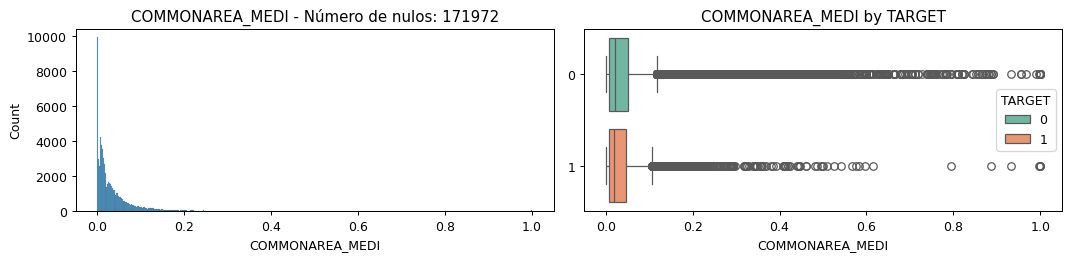

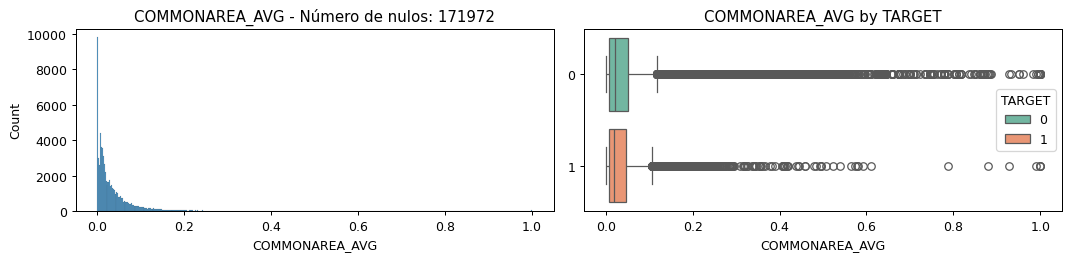

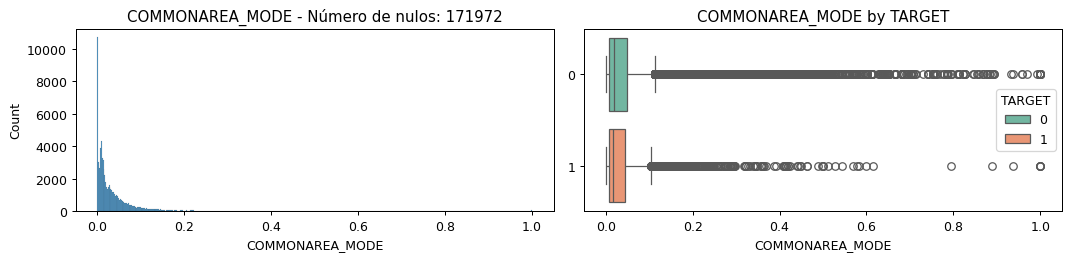

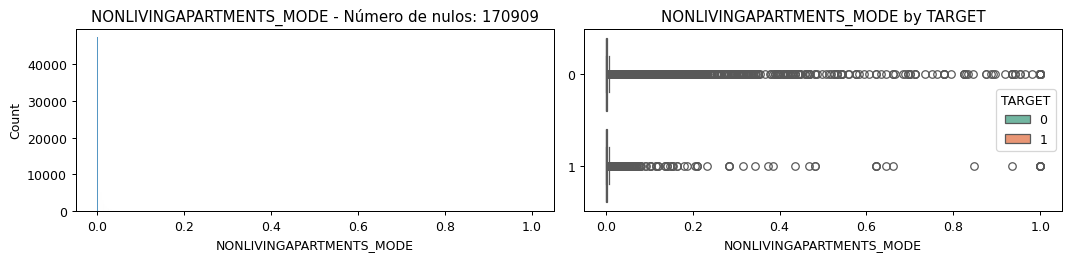

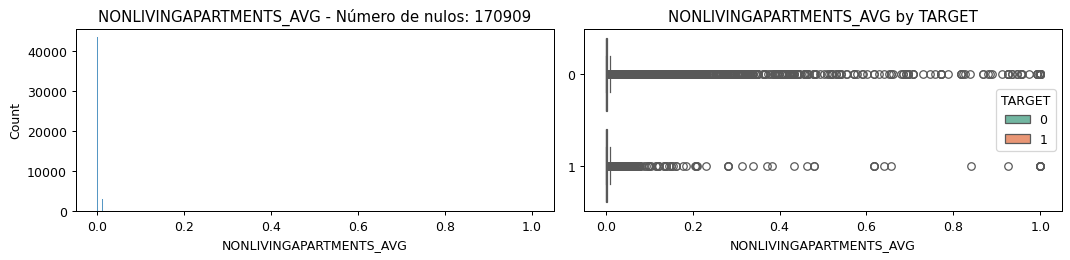

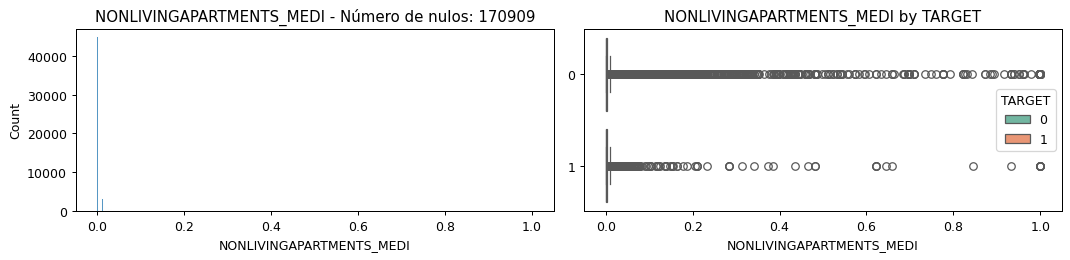

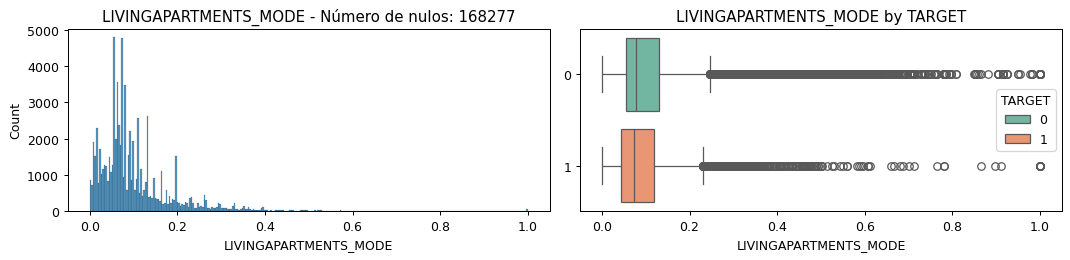

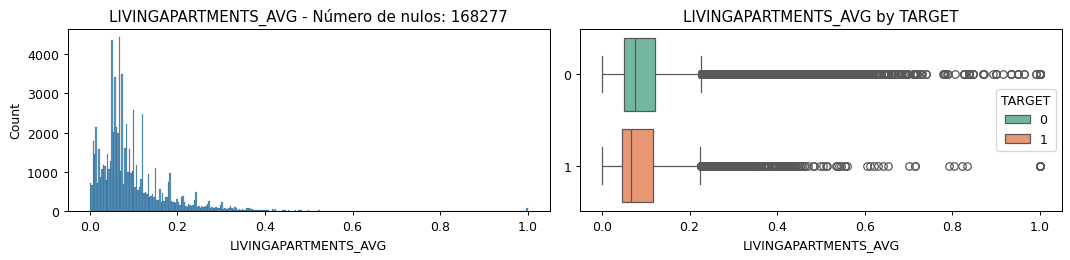

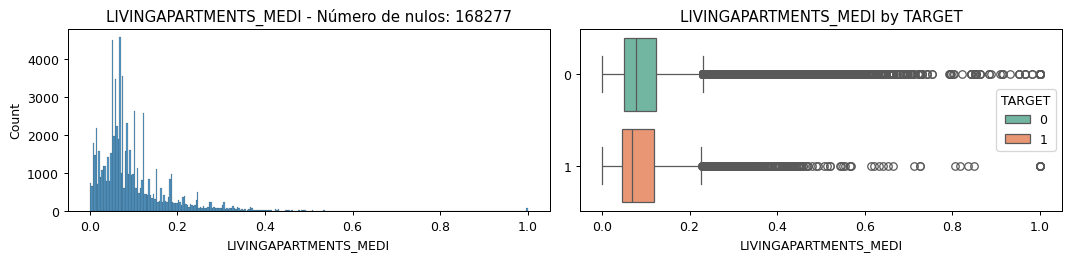

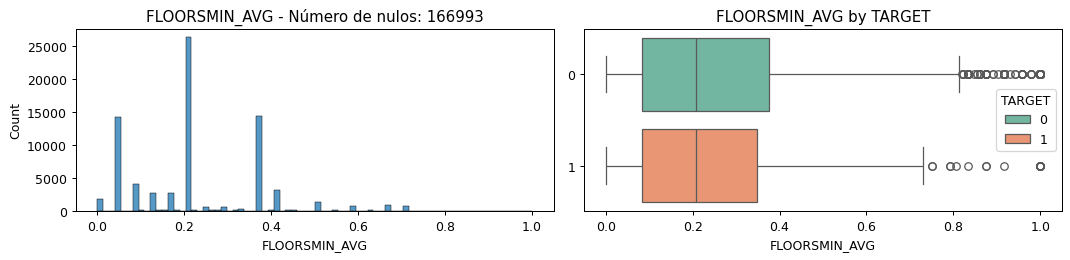

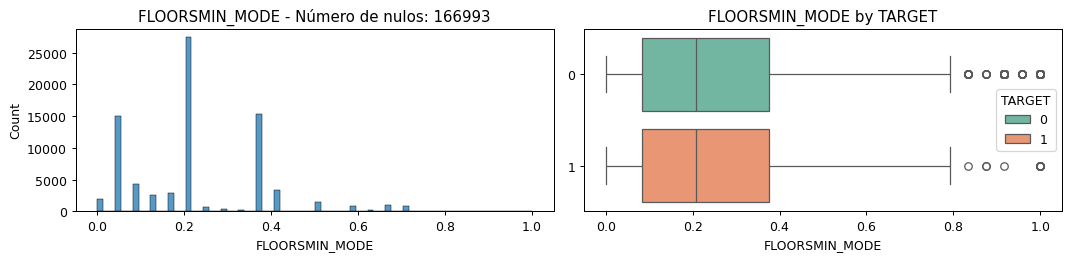

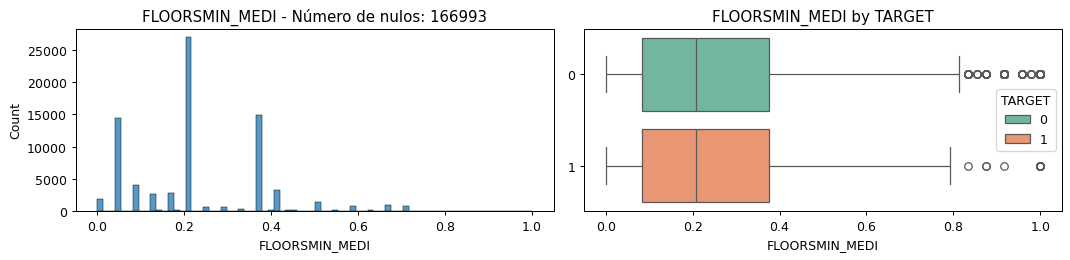

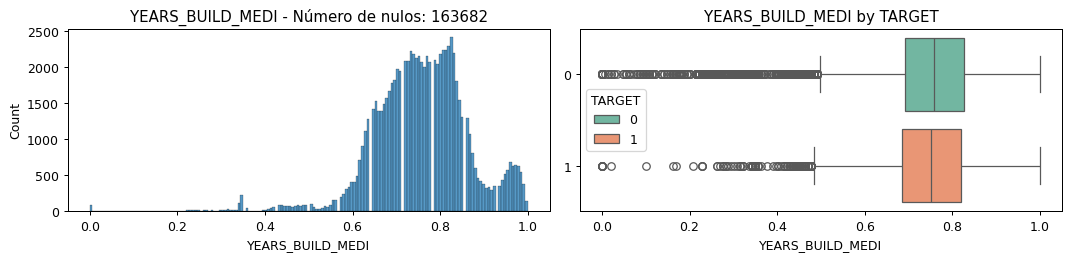

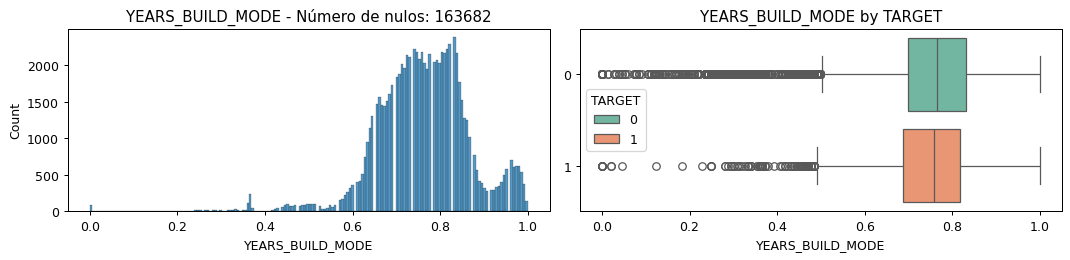

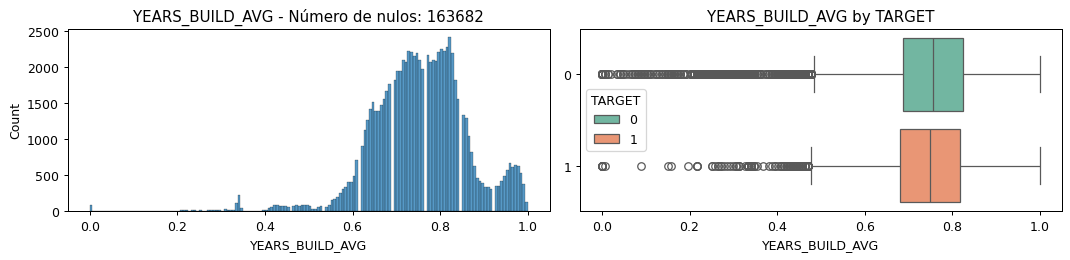

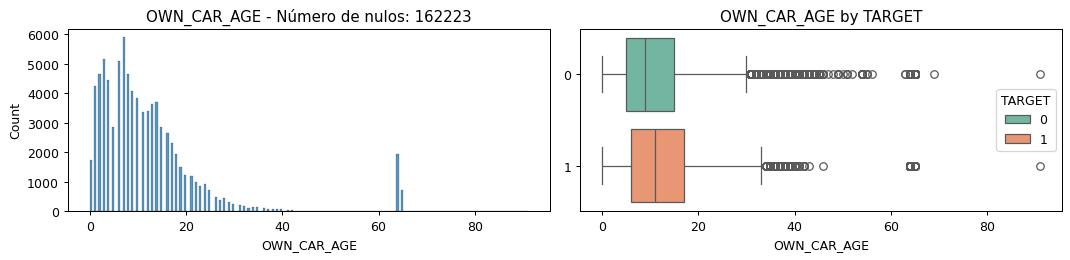

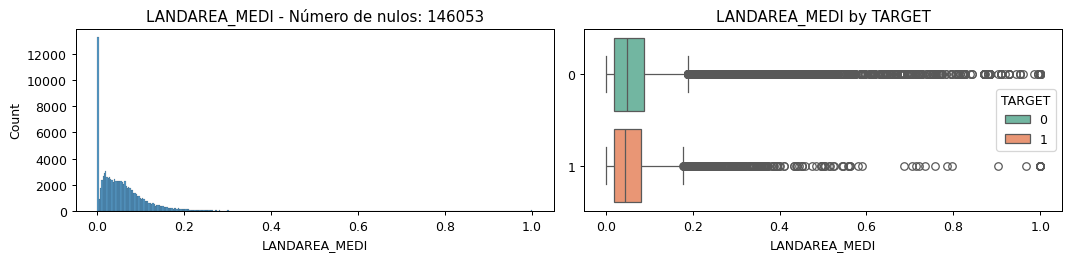

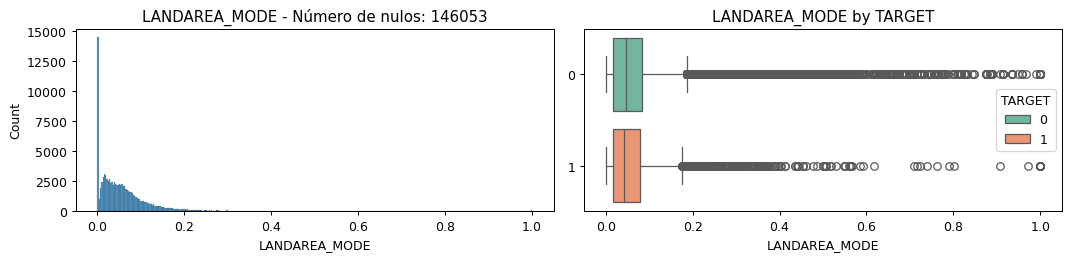

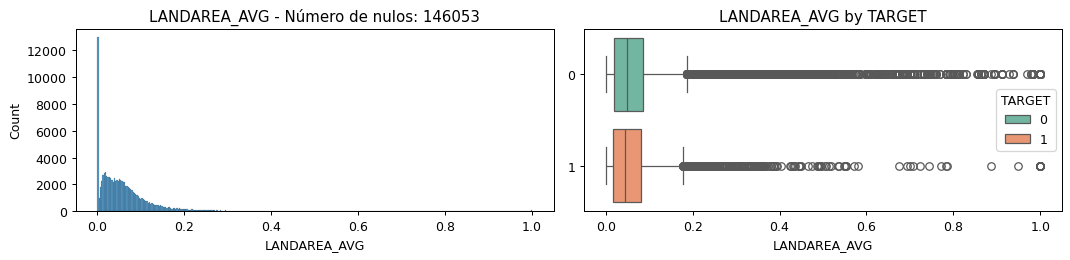

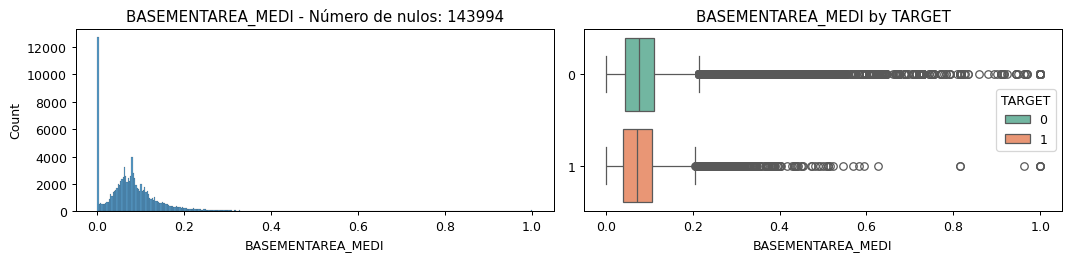

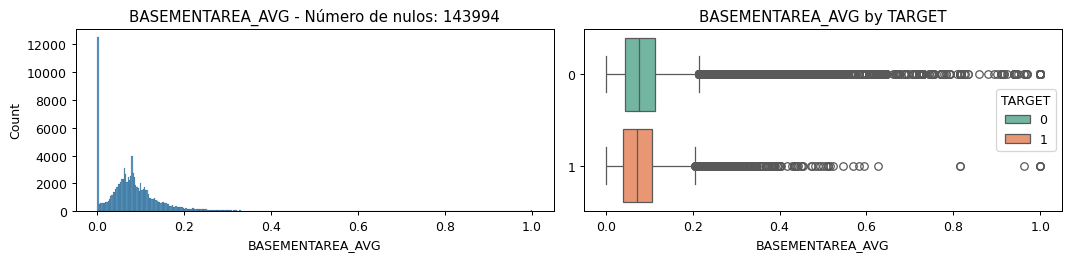

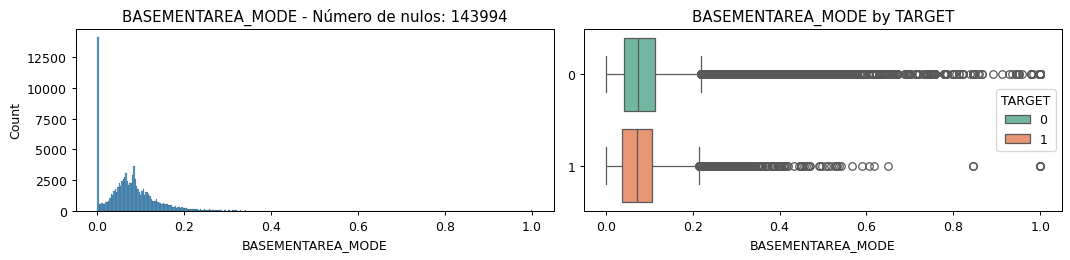

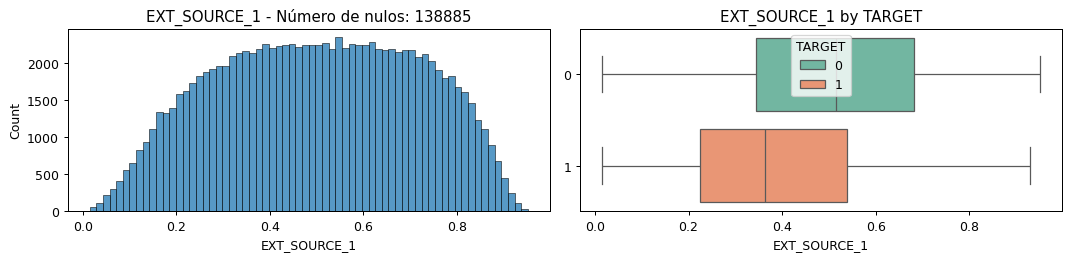

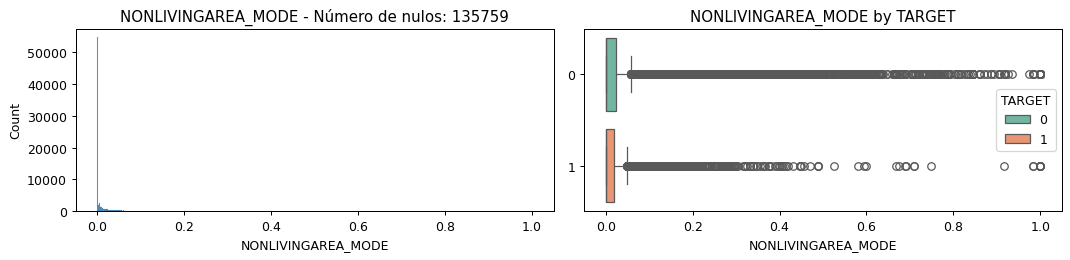

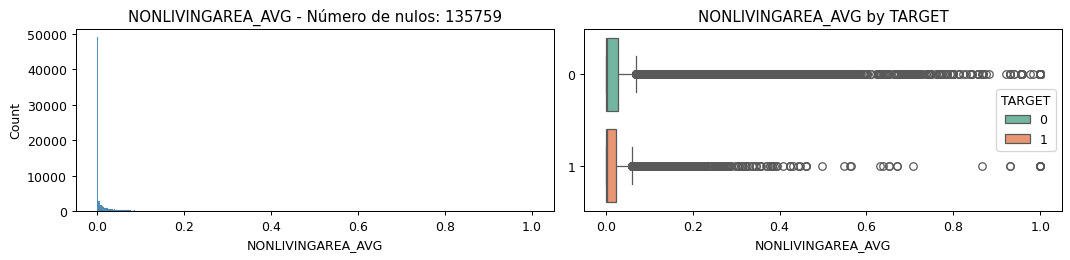

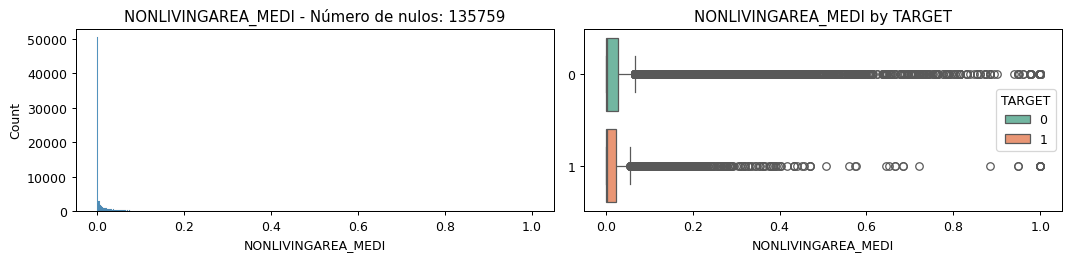

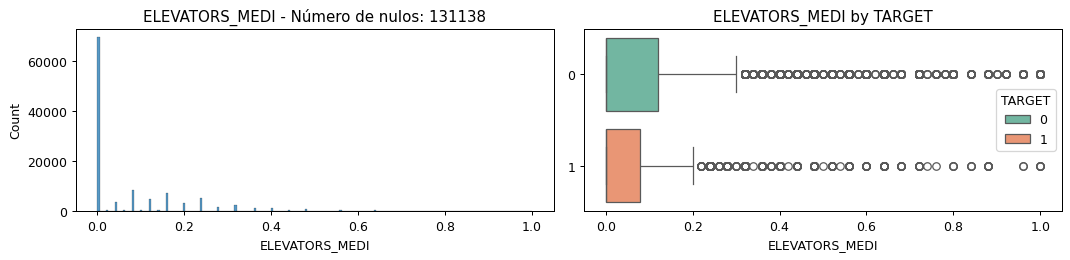

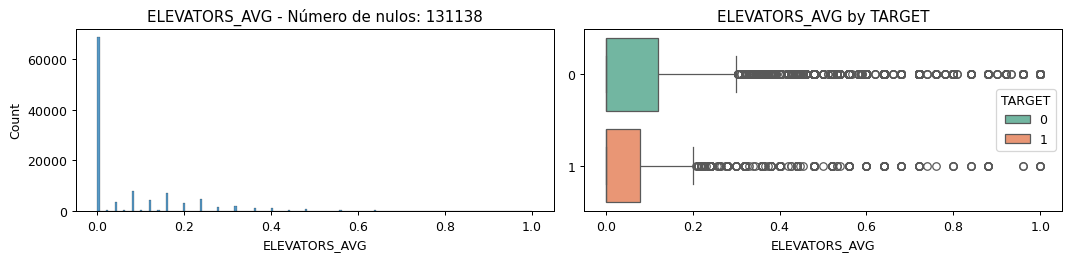

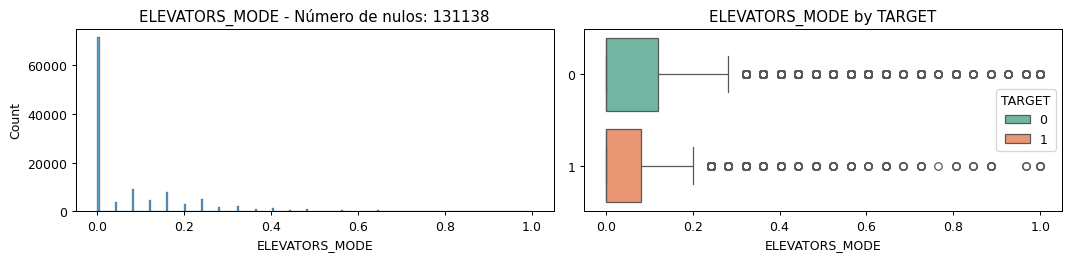

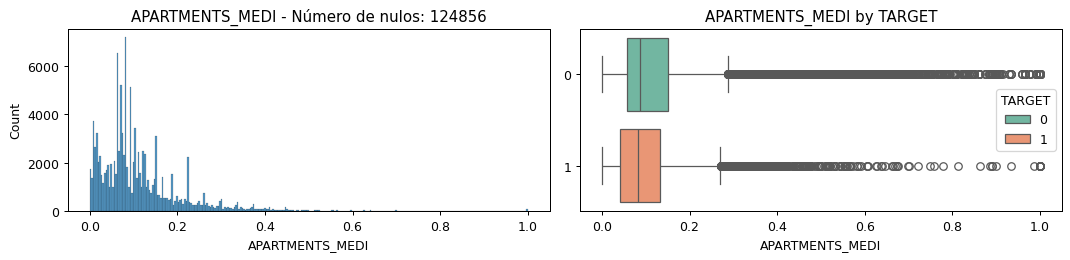

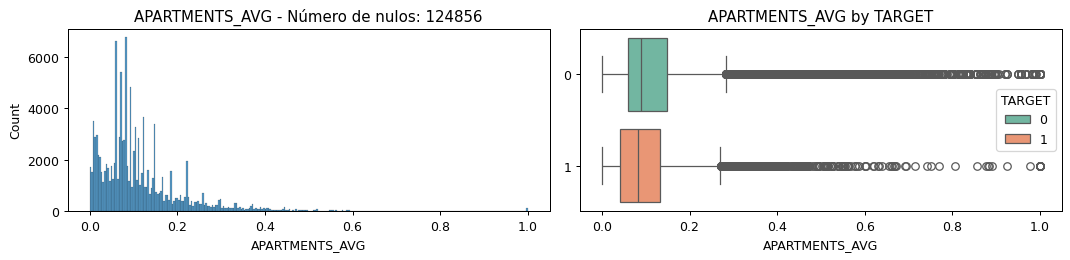

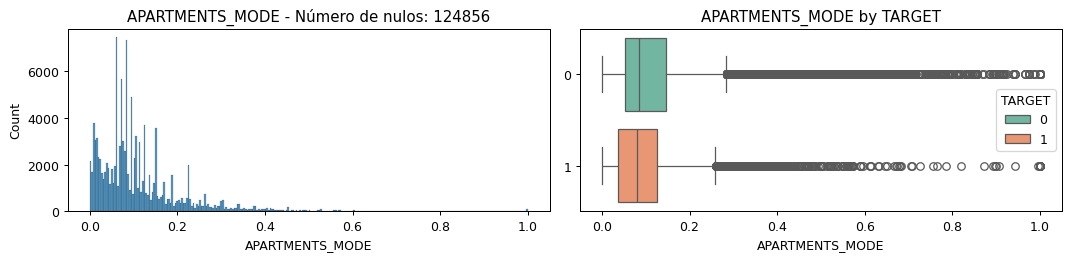

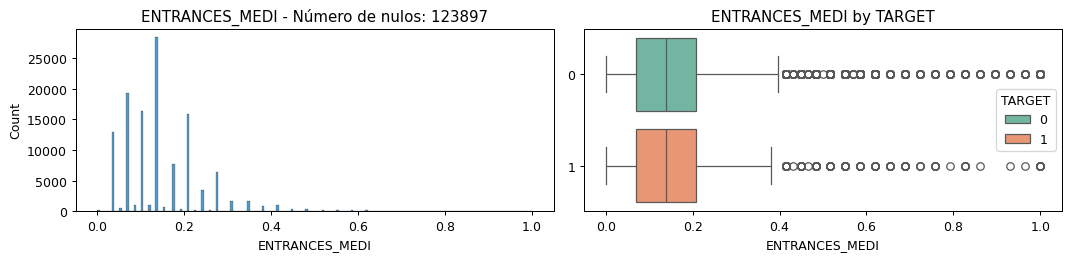

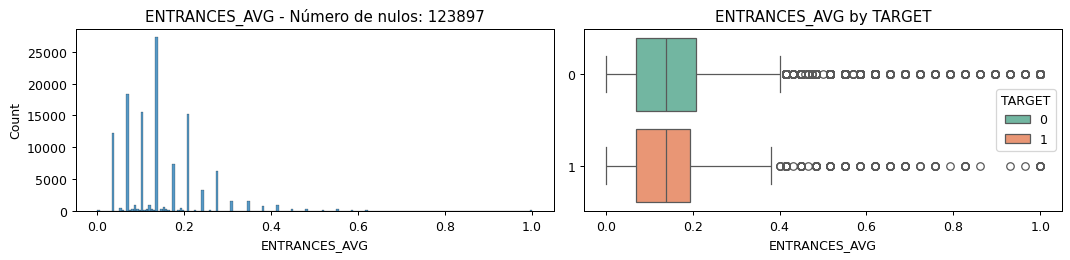

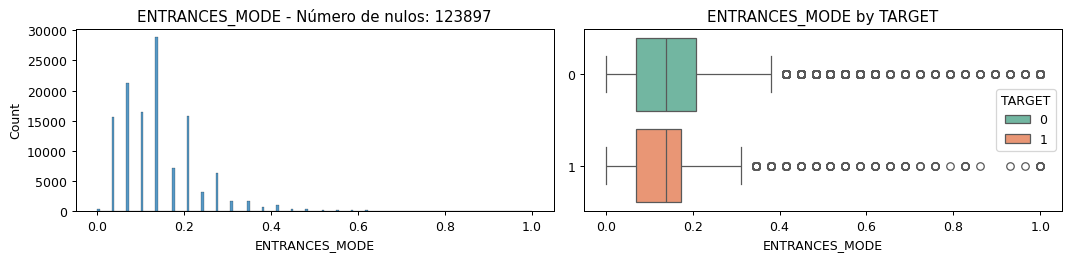

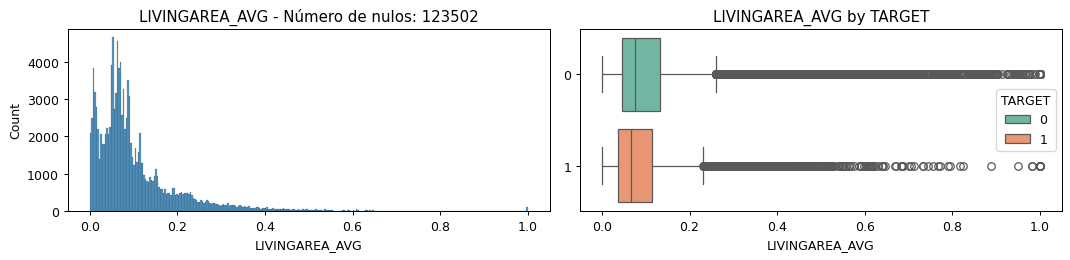

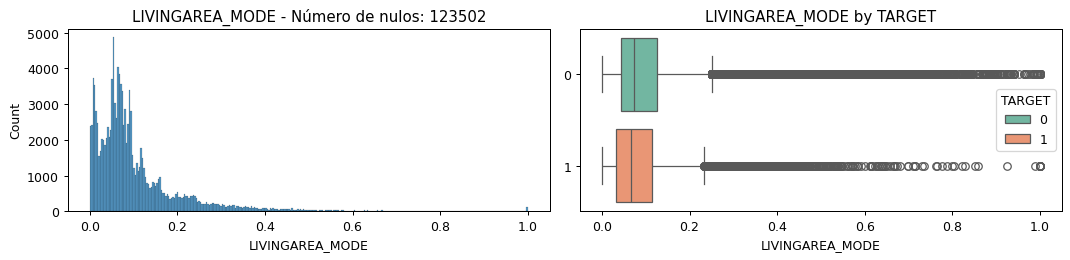

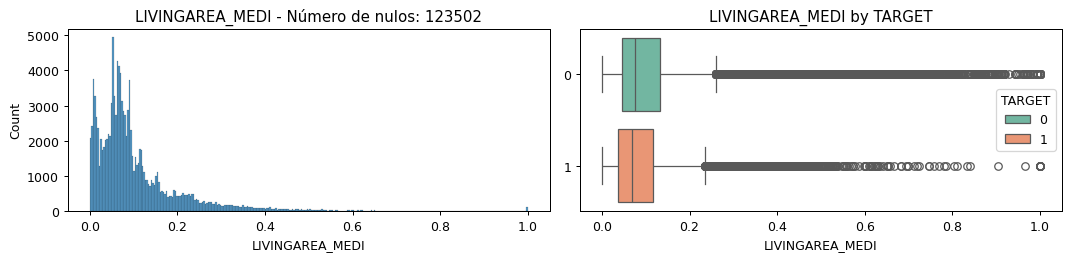

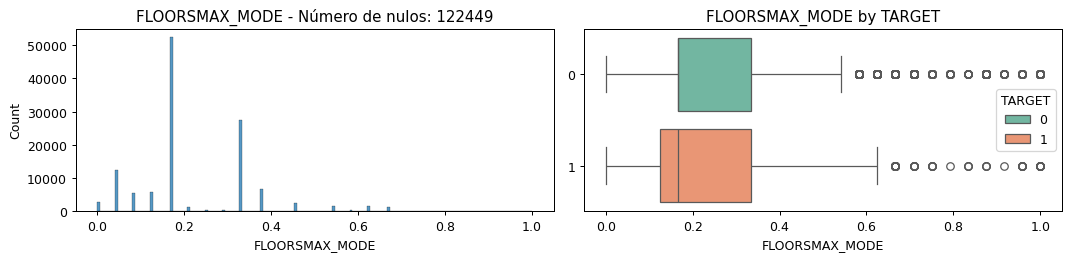

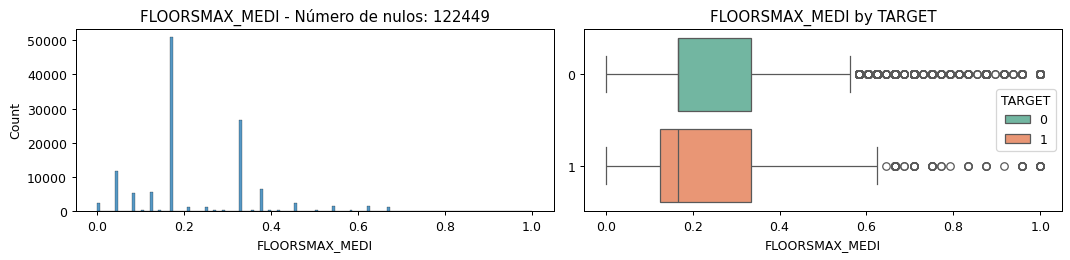

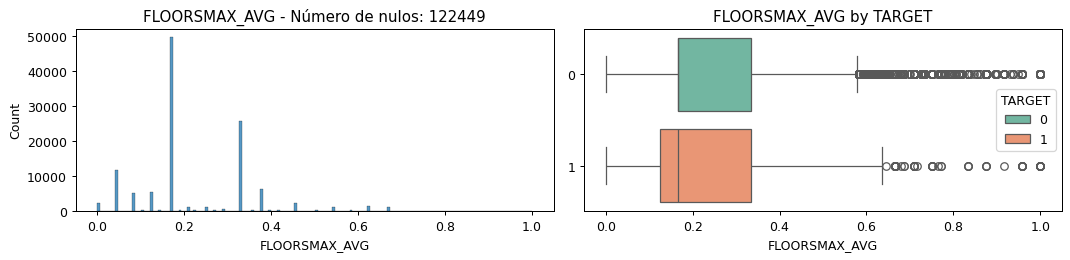

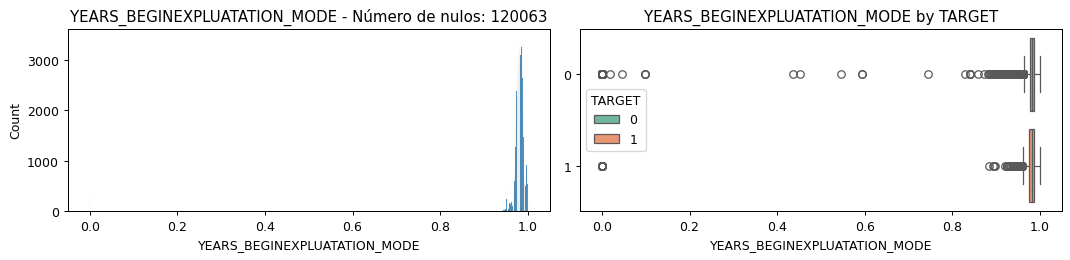

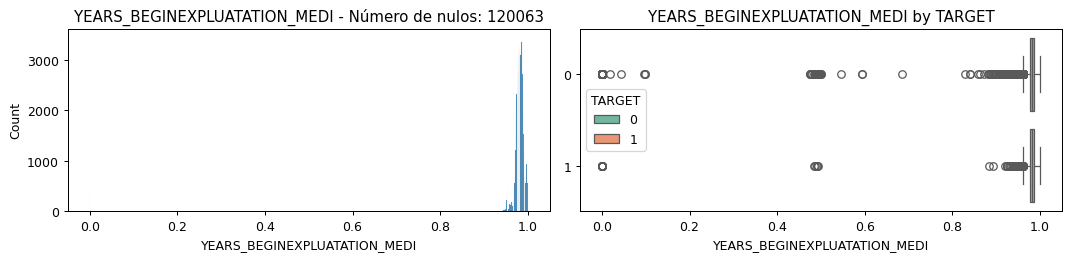

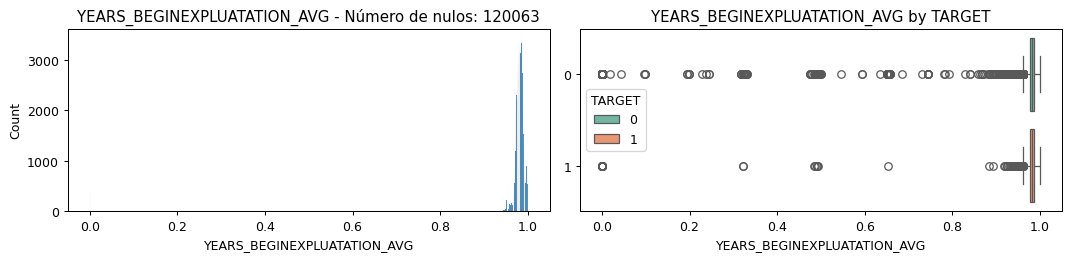

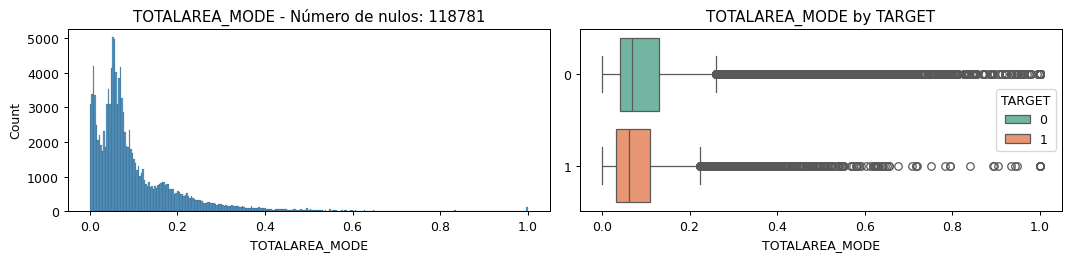

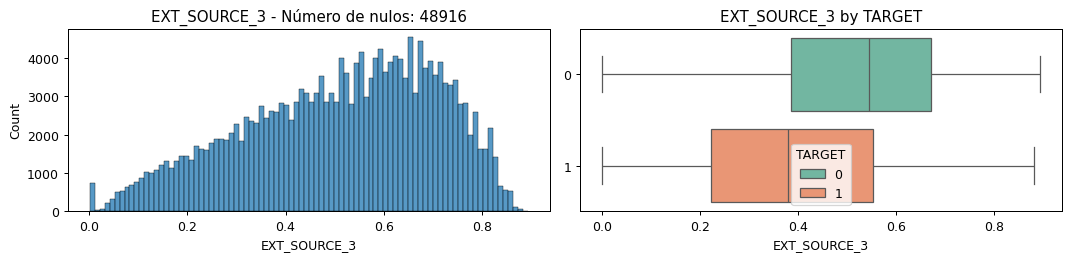

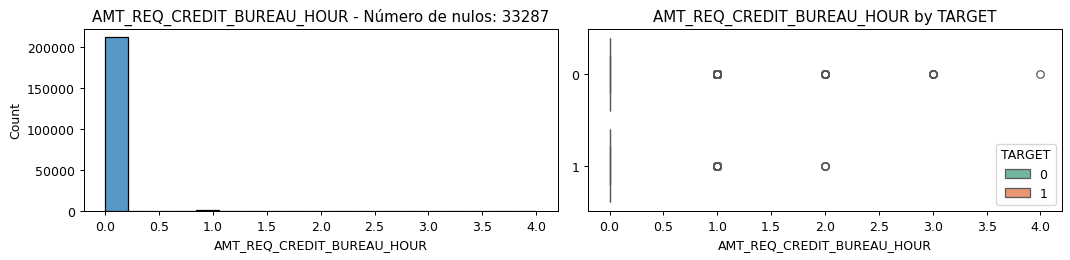

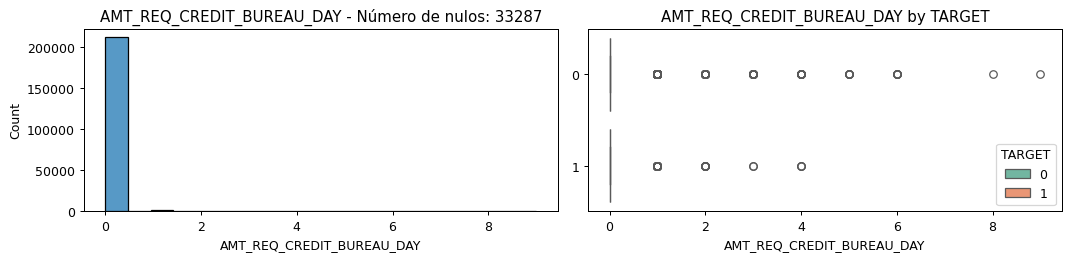

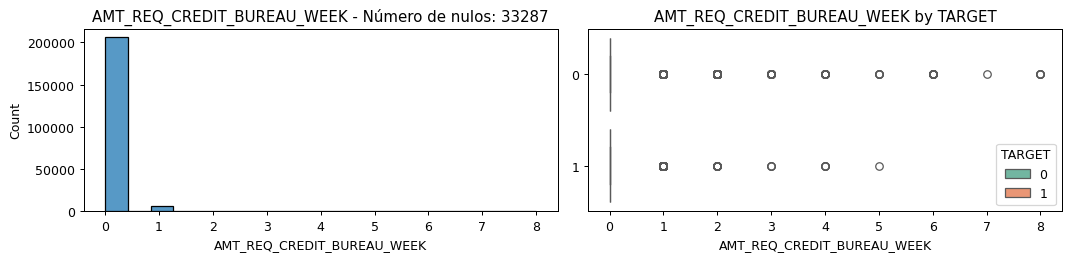

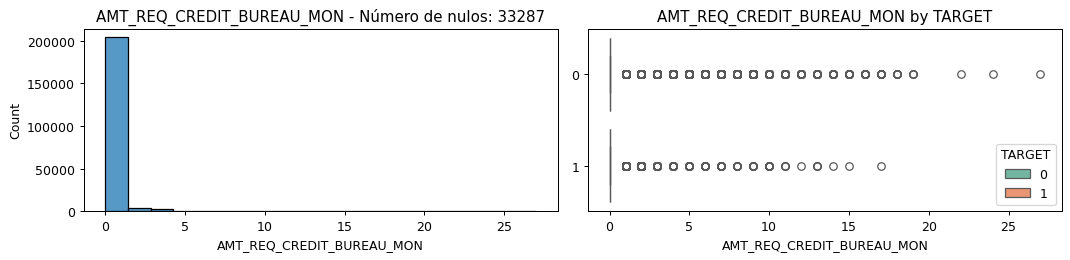

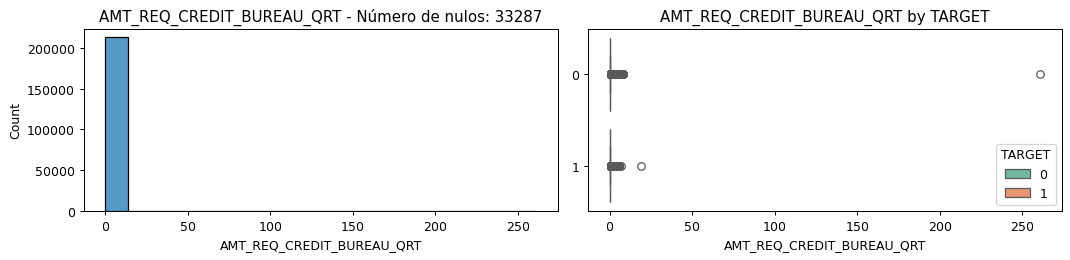

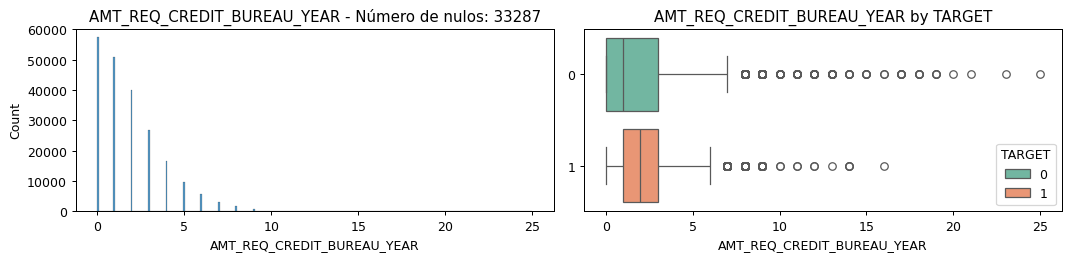

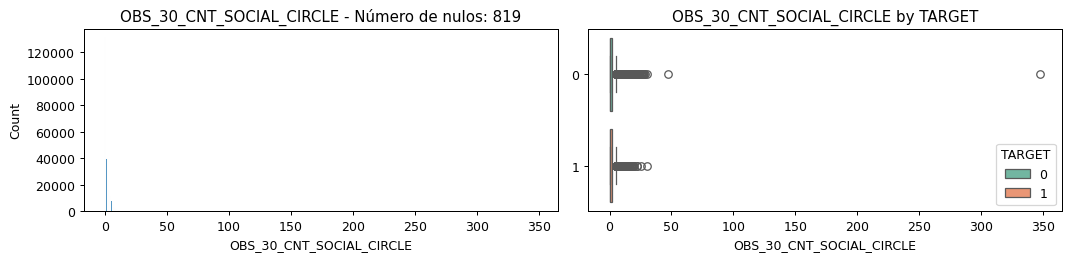

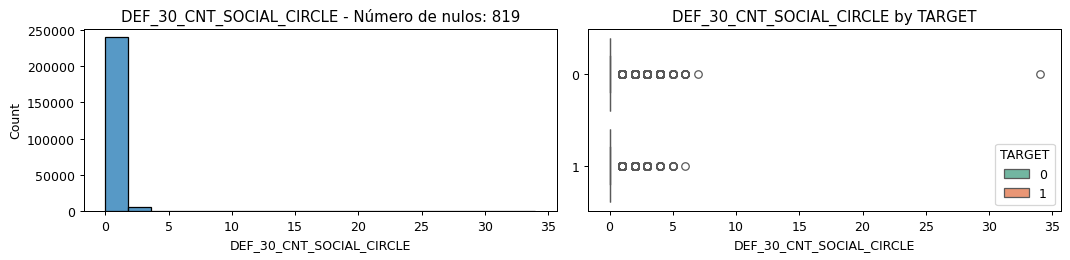

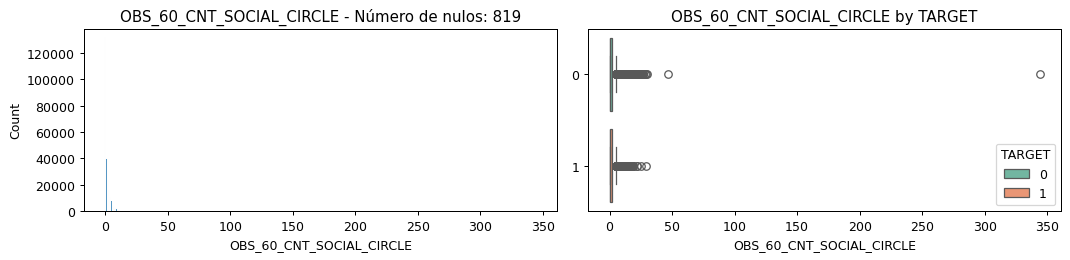

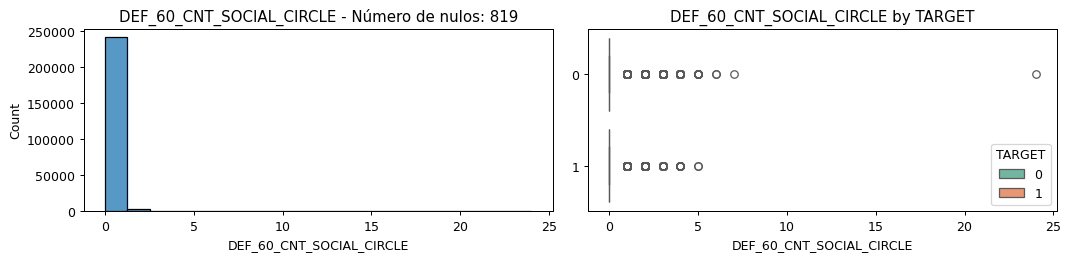

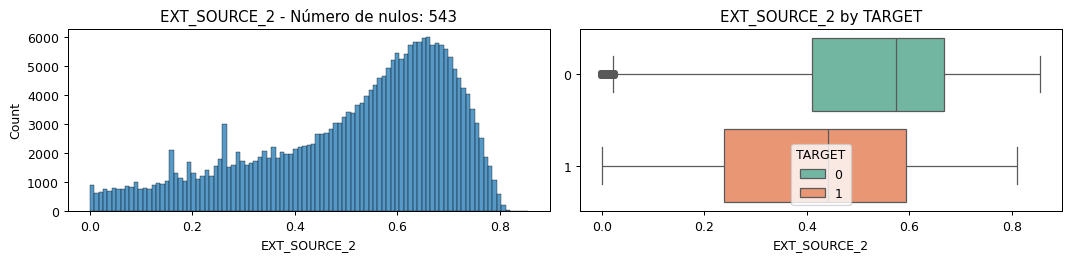

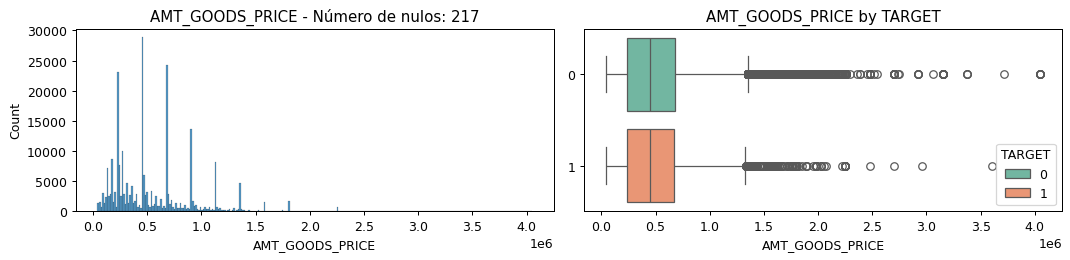

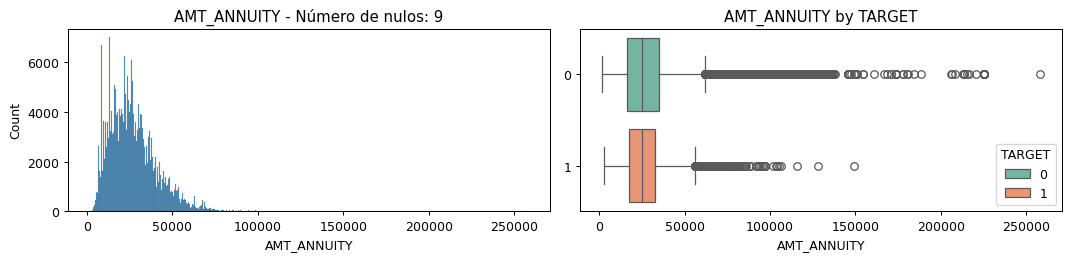

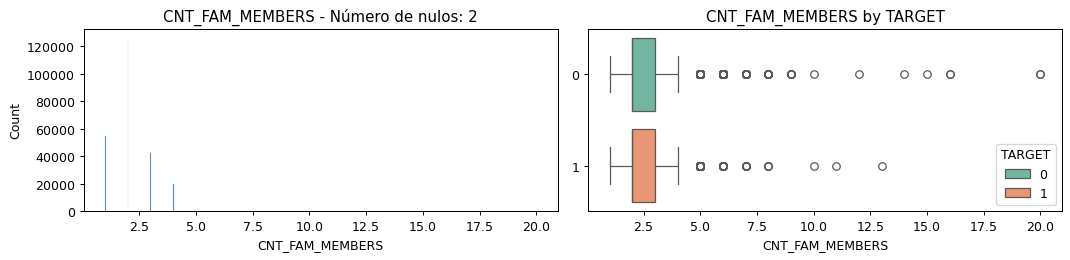

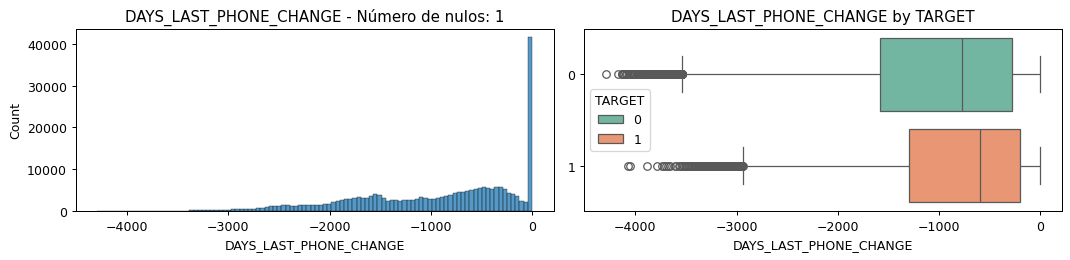

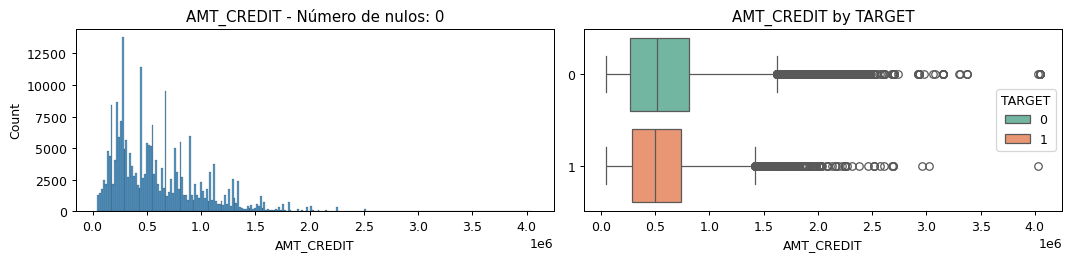

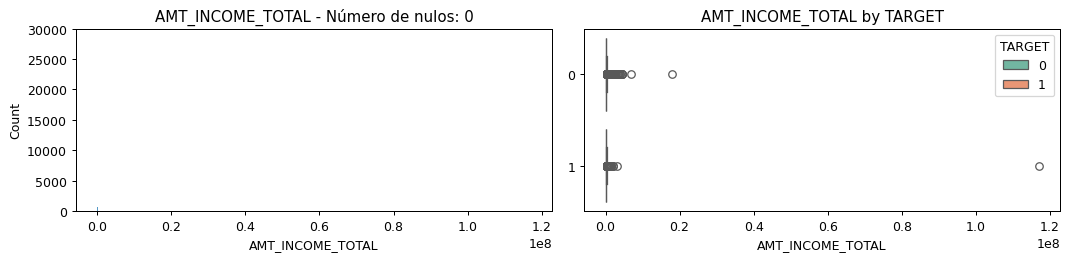

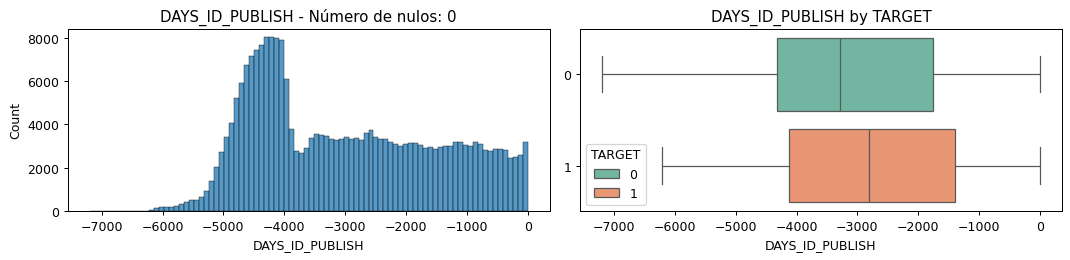

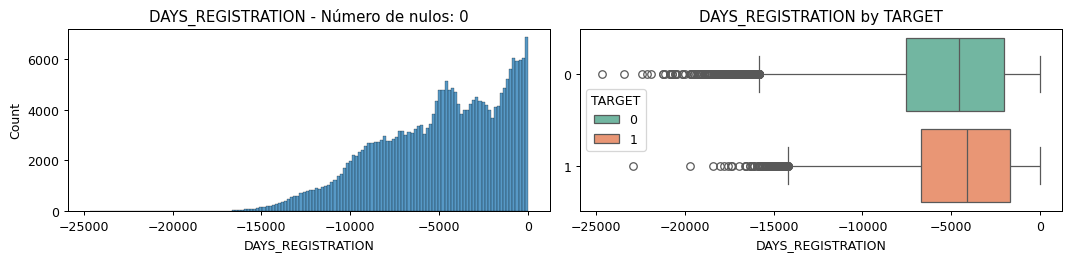

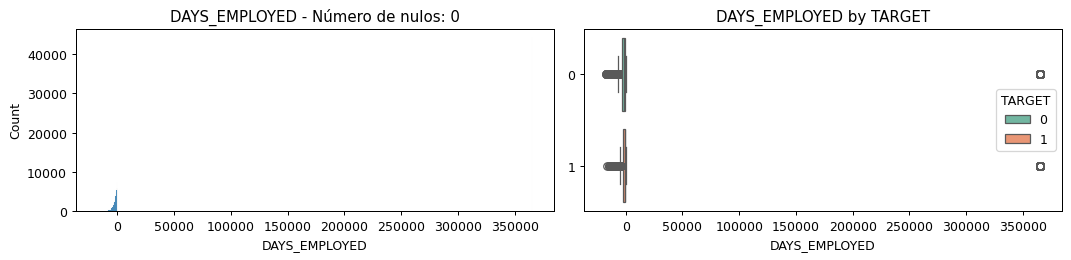

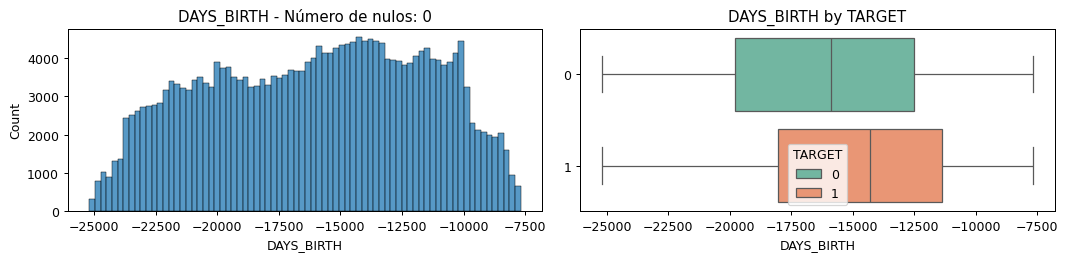

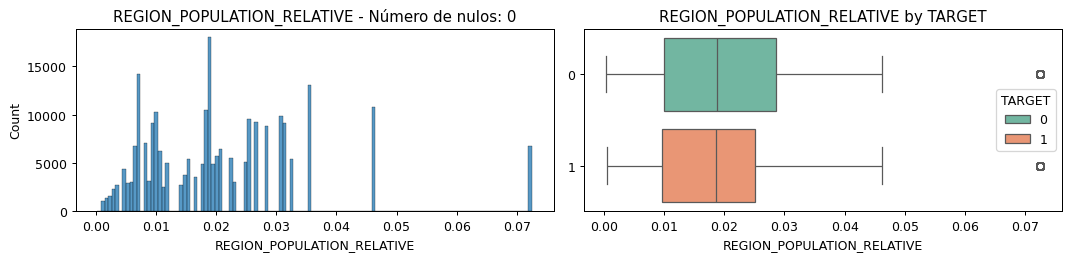

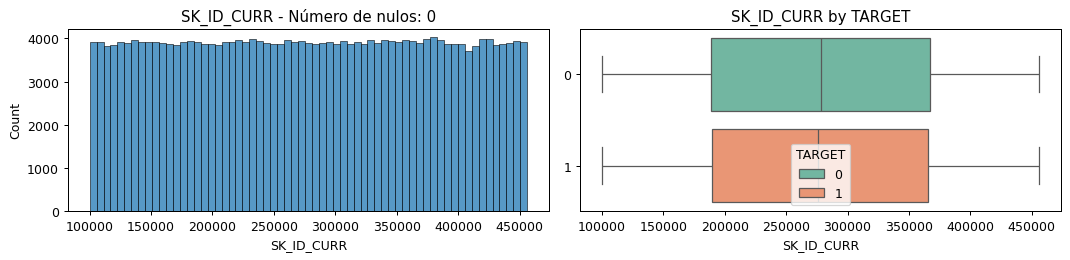

In [ ]:

# Suprimir advertencias
warnings.filterwarnings('ignore')

# Traverse all columns of train and make graphs only for continuous variables
for i in list(pd_loan_train.columns):
    # Check if the column is continuous (dtype float or int)
    if (pd_loan_train[i].dtype in ['float64', 'int64']) & (i != 'TARGET'):
        # Call function for continuous variables
        plot_continuous_feature(pd_loan_train, col_name=i, target='TARGET')

A continuación se realizan los gráficos para comparar las variables categóricas con la variable objetivo 'TARGET'

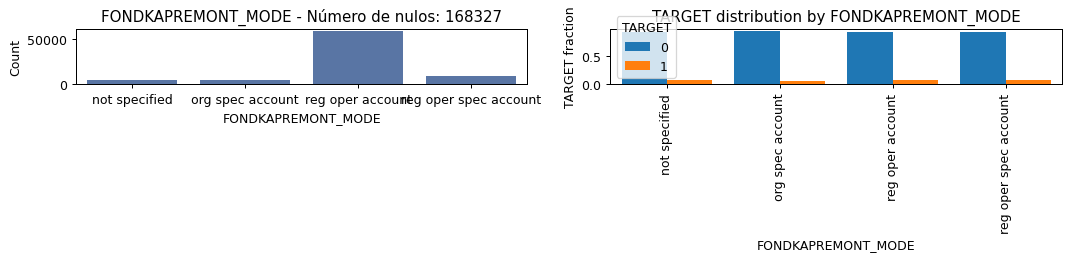

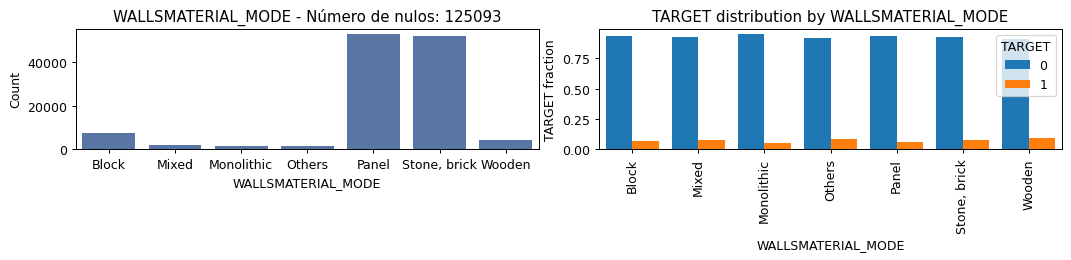

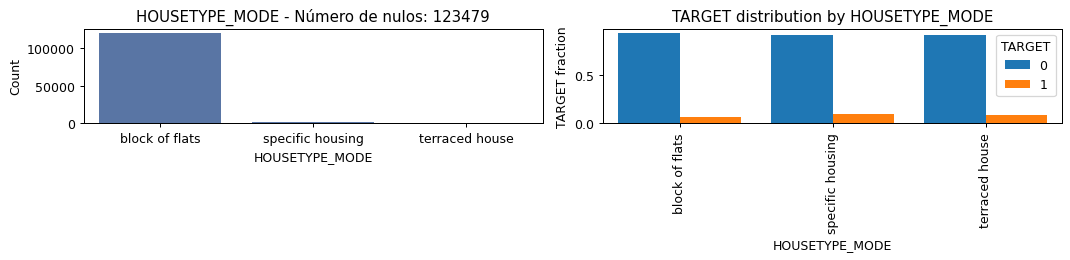

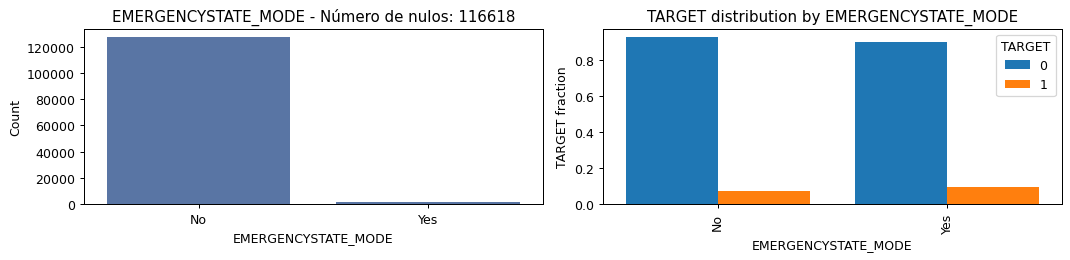

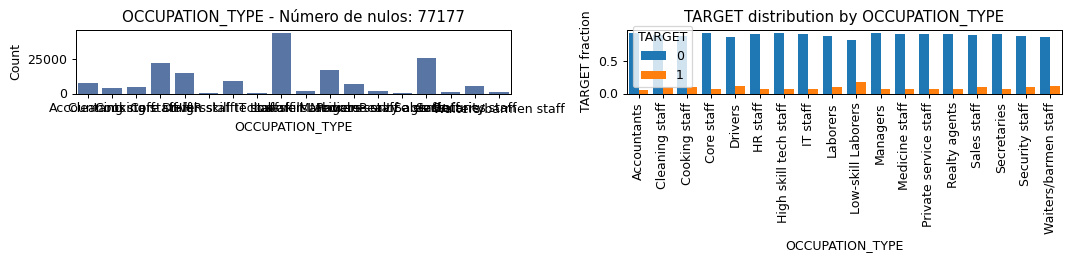

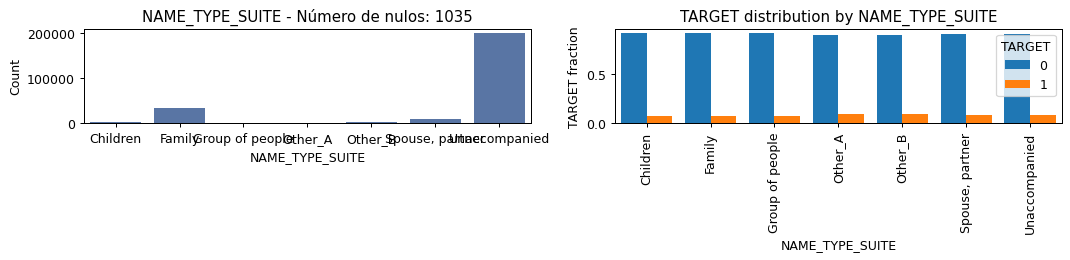

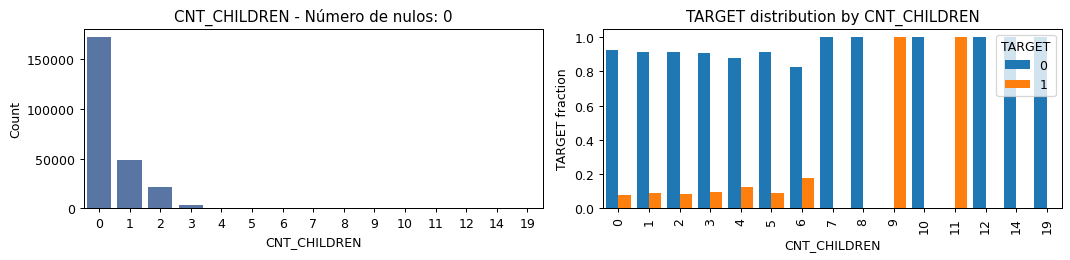

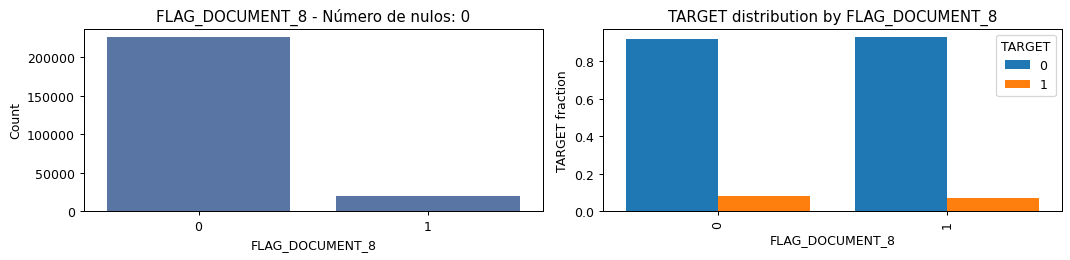

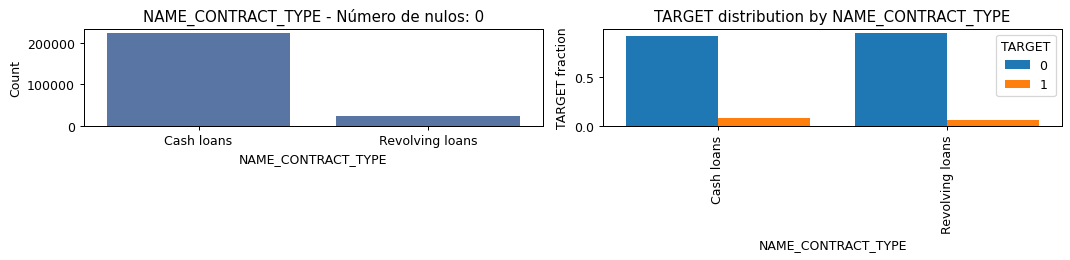

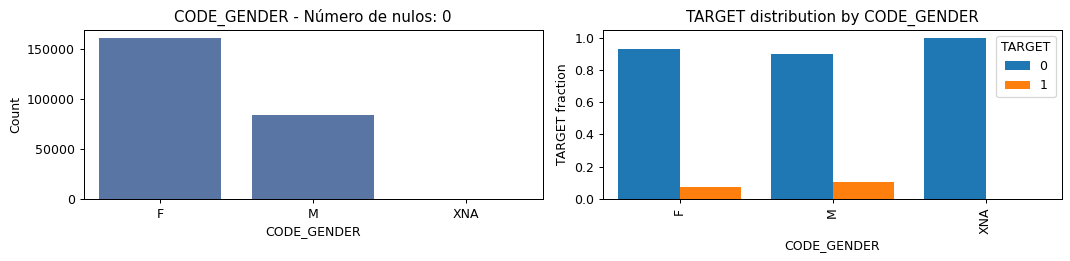

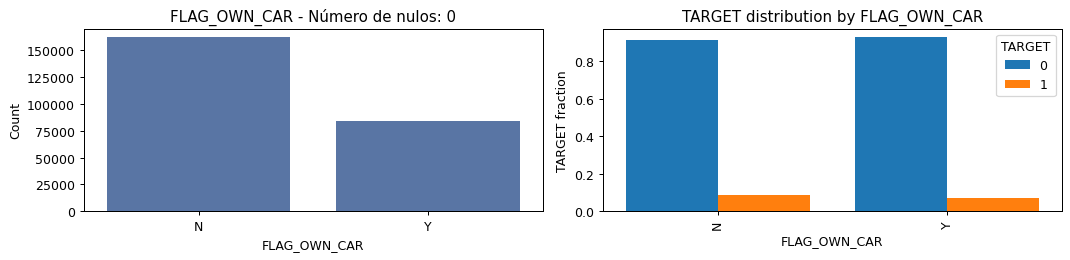

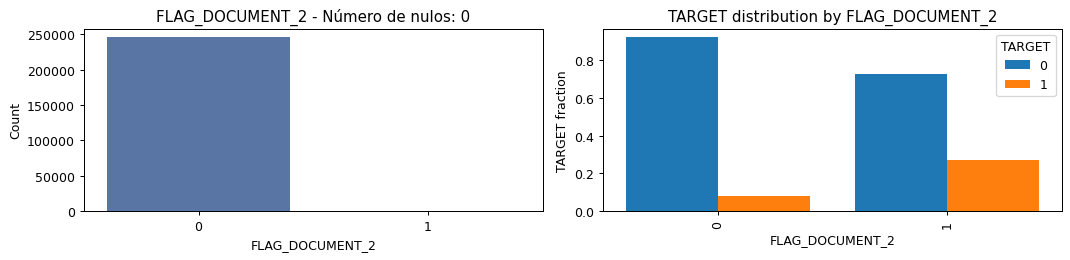

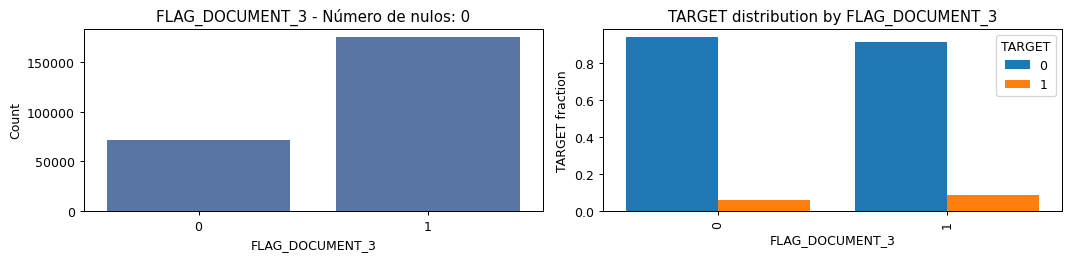

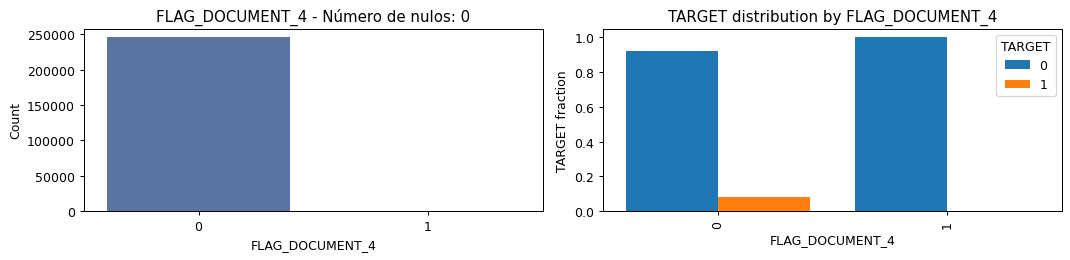

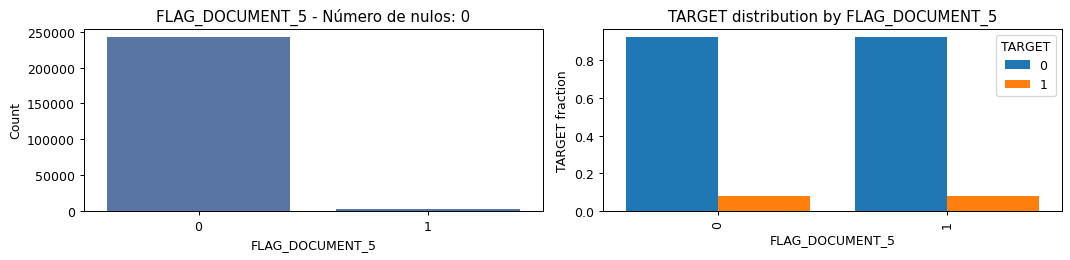

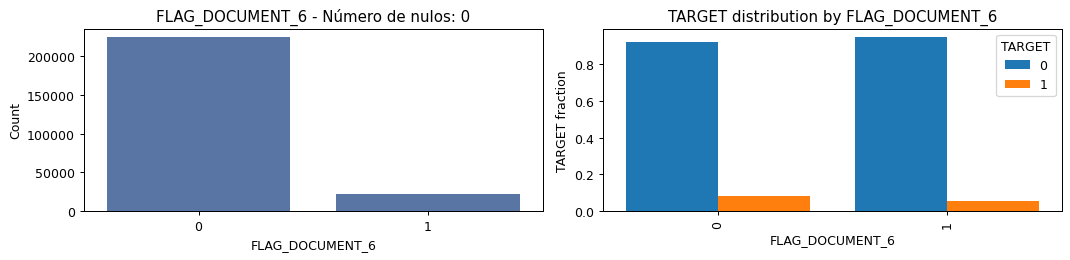

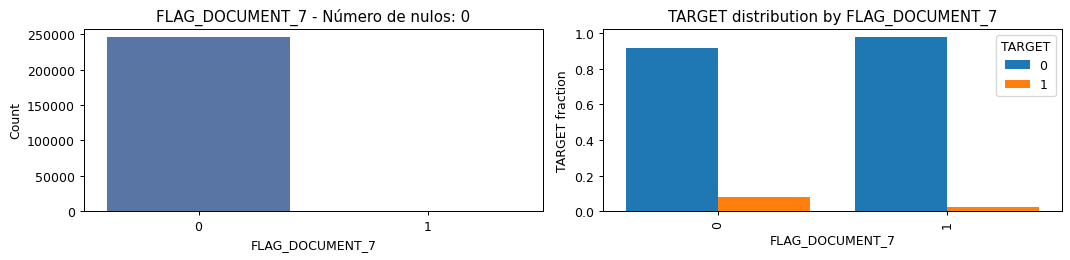

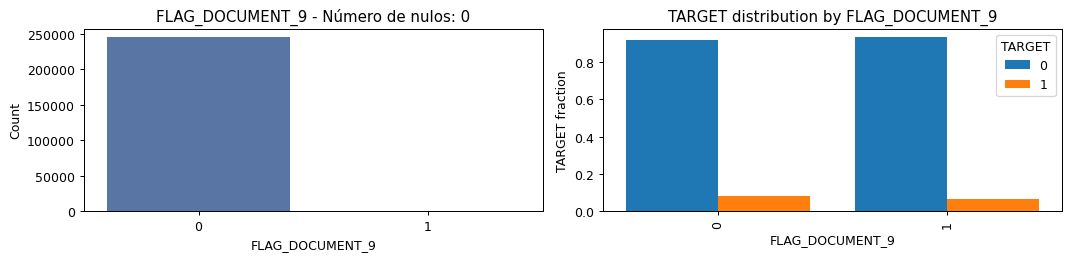

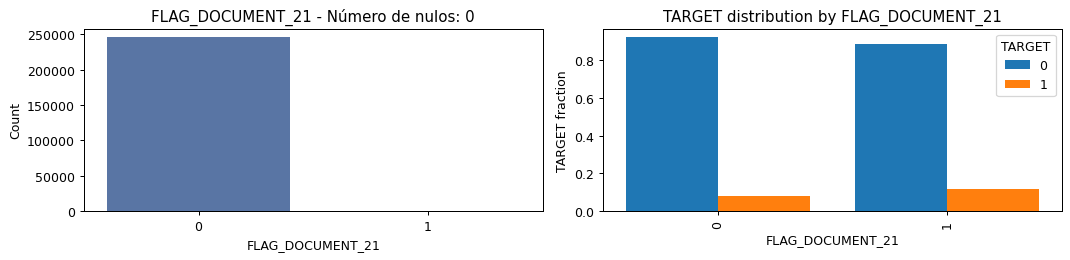

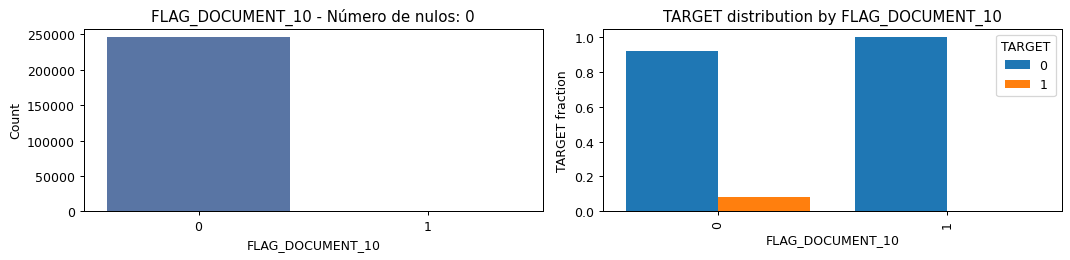

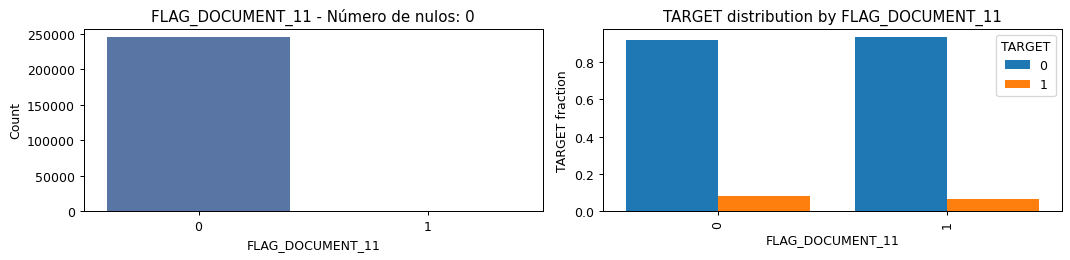

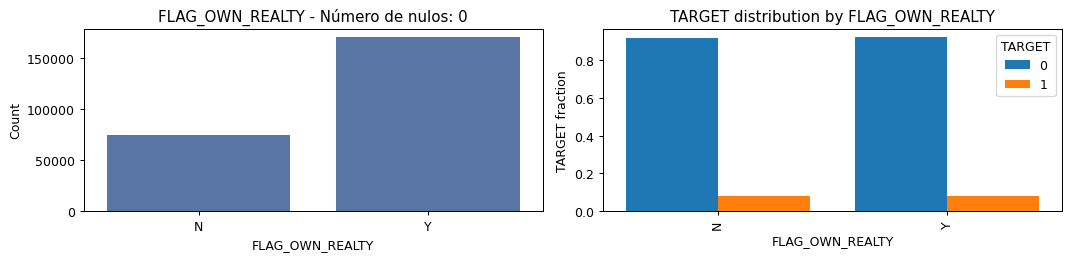

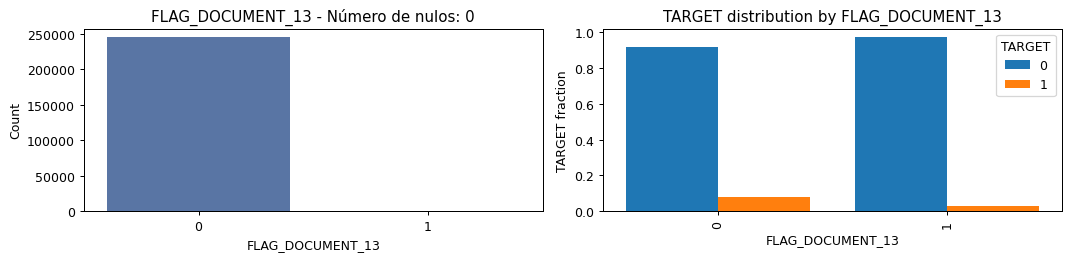

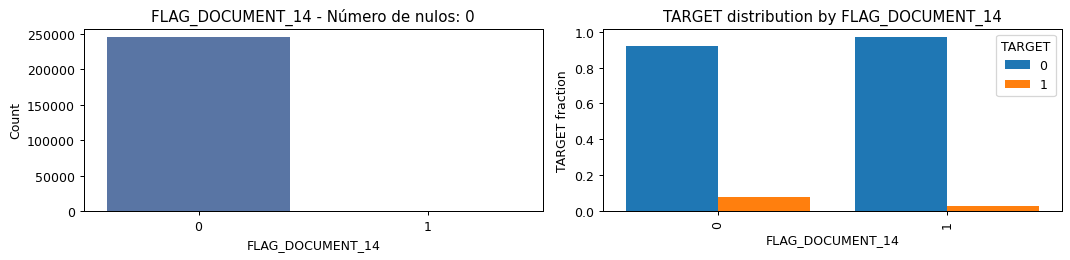

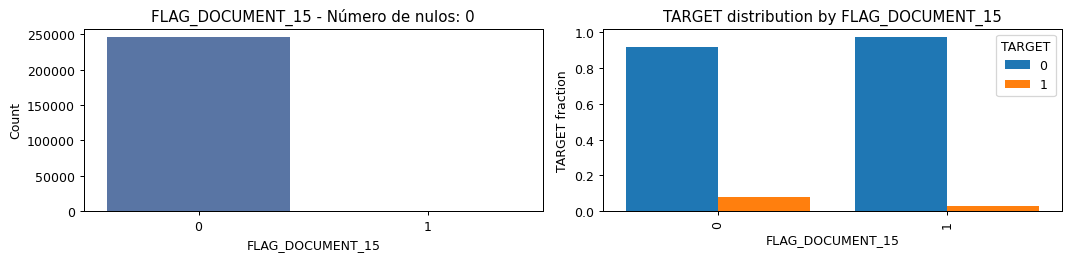

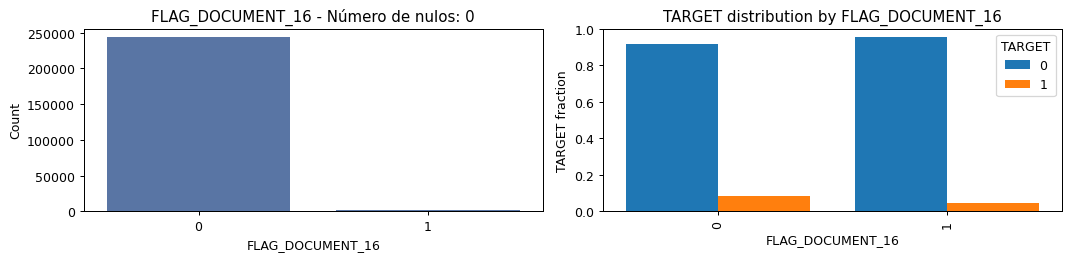

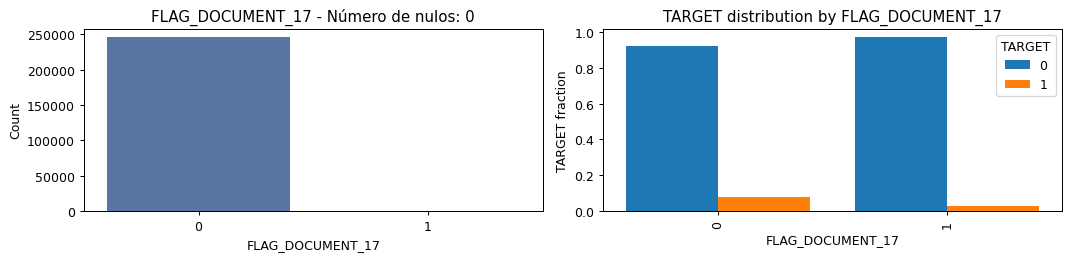

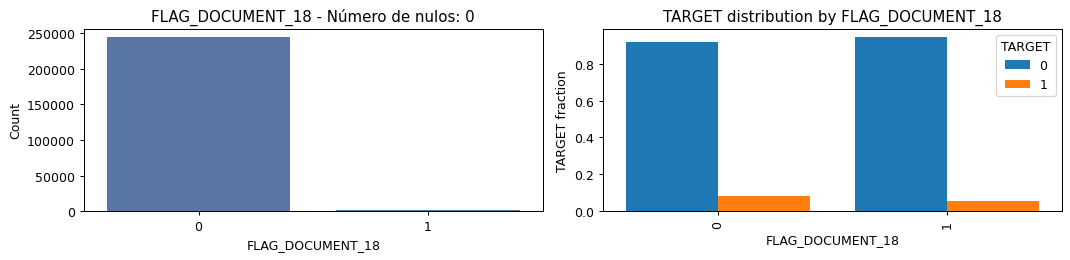

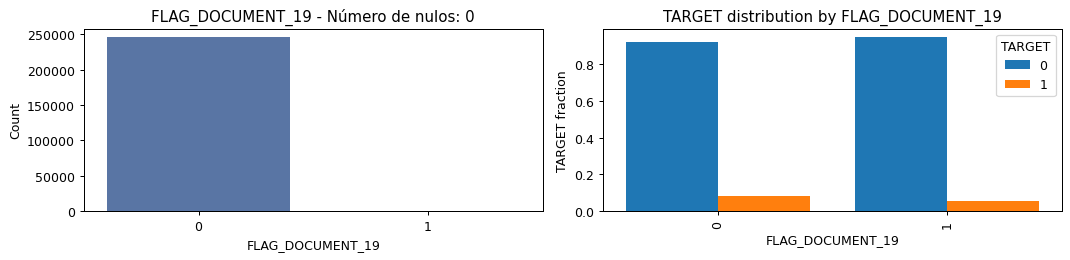

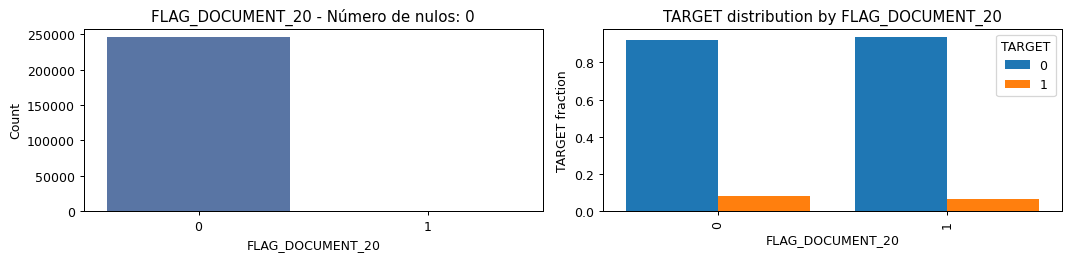

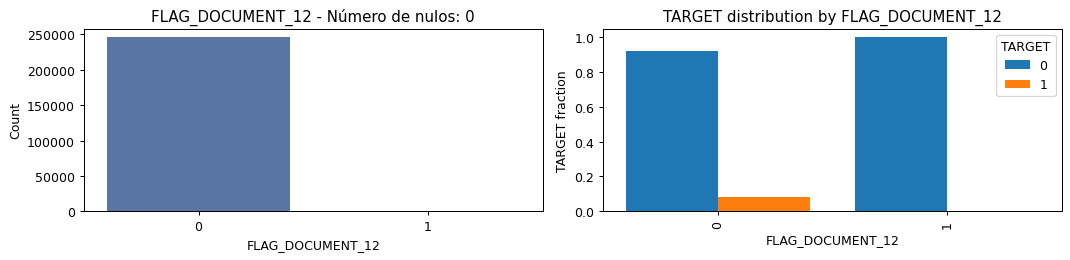

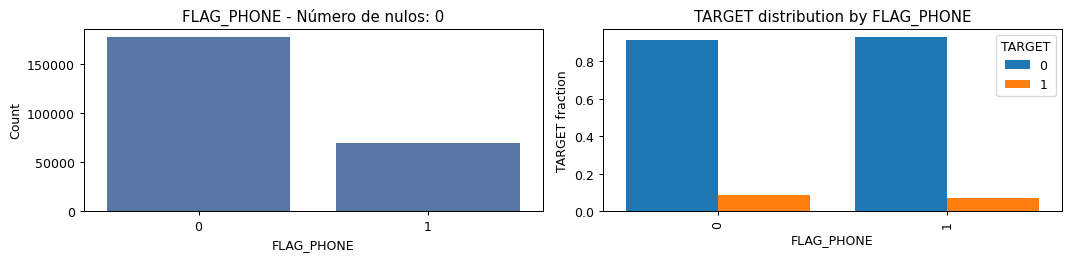

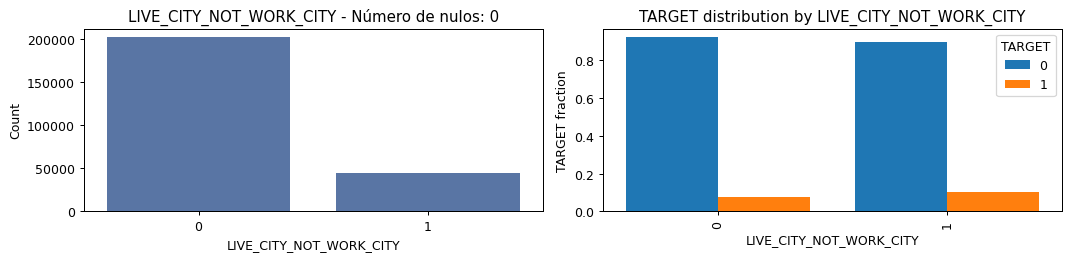

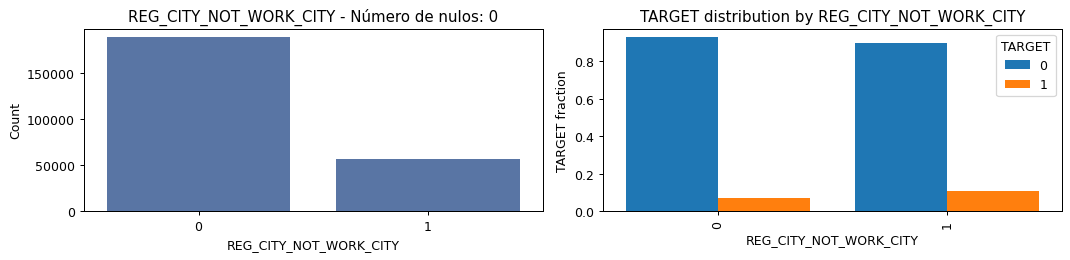

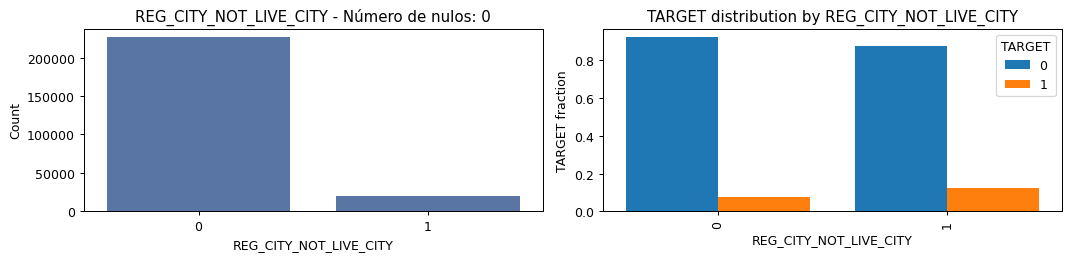

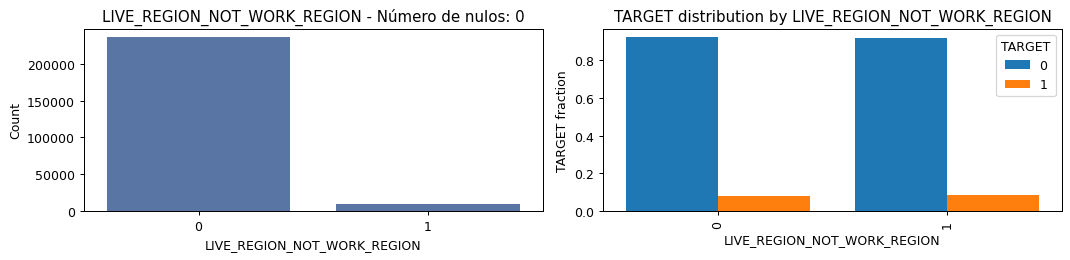

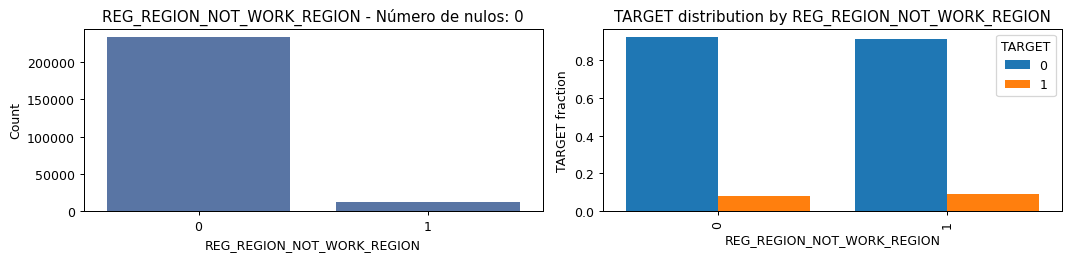

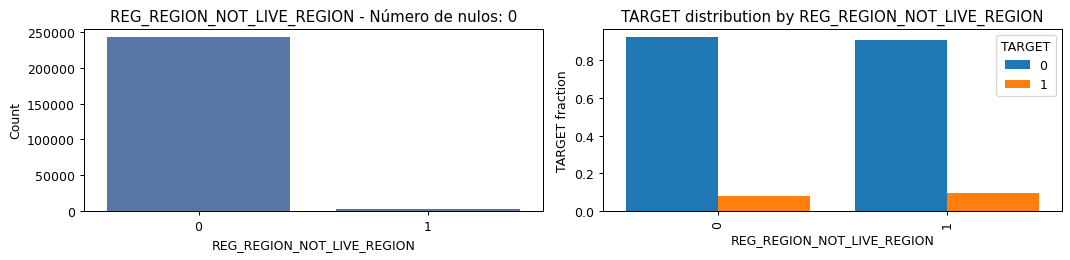

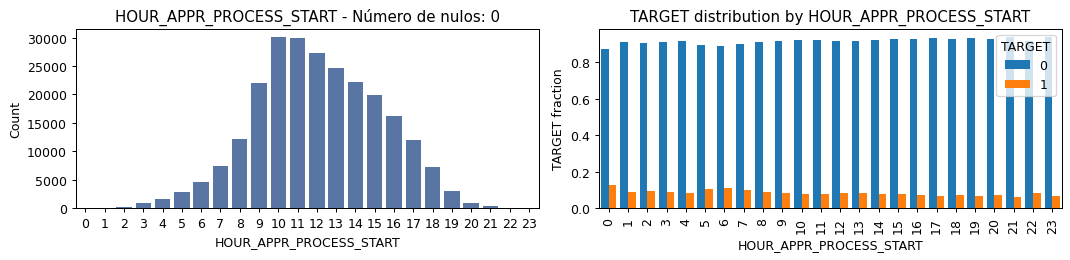

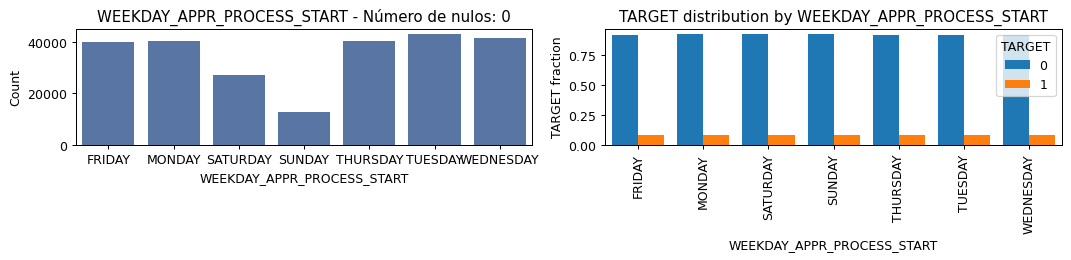

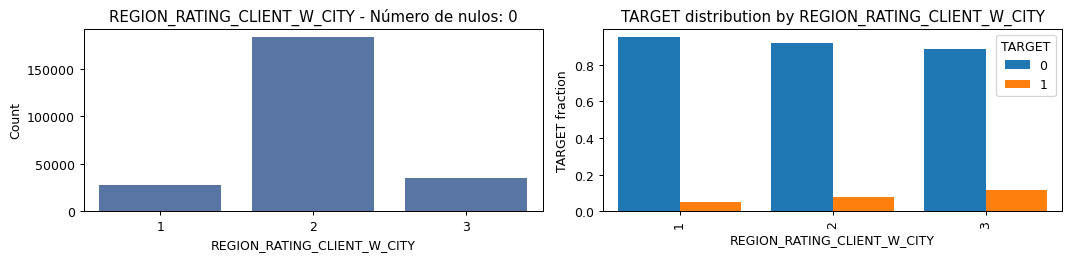

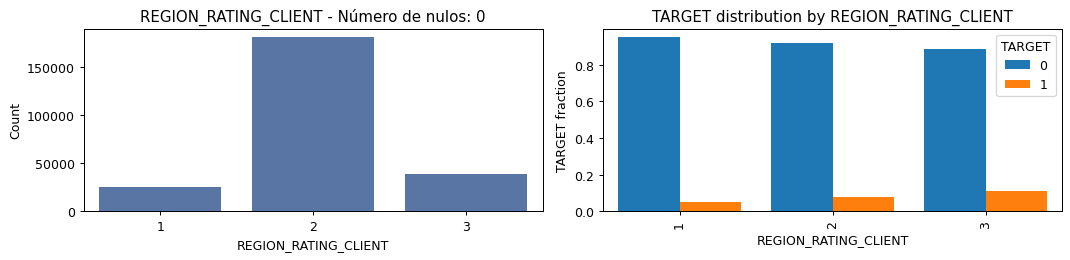

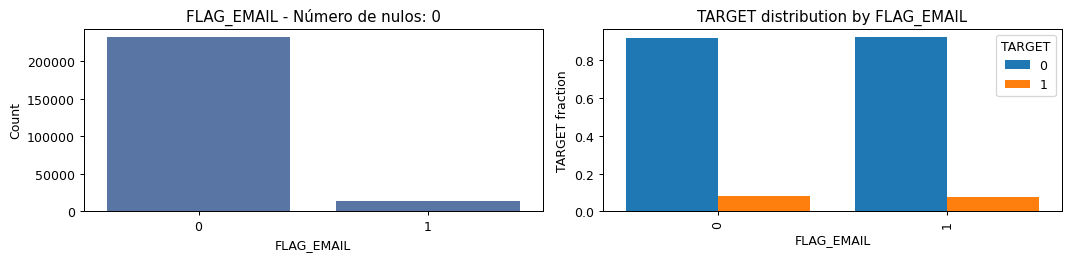

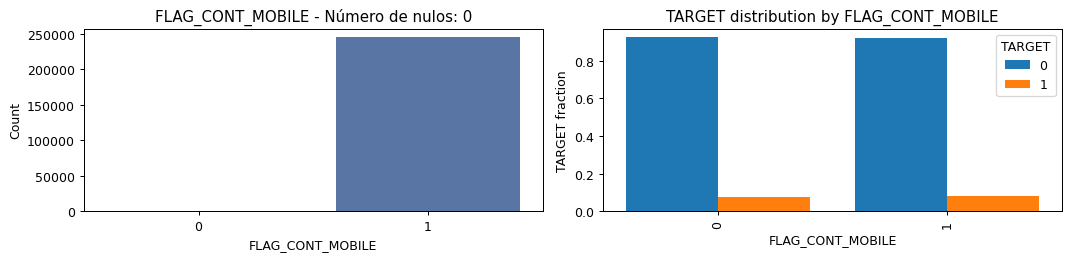

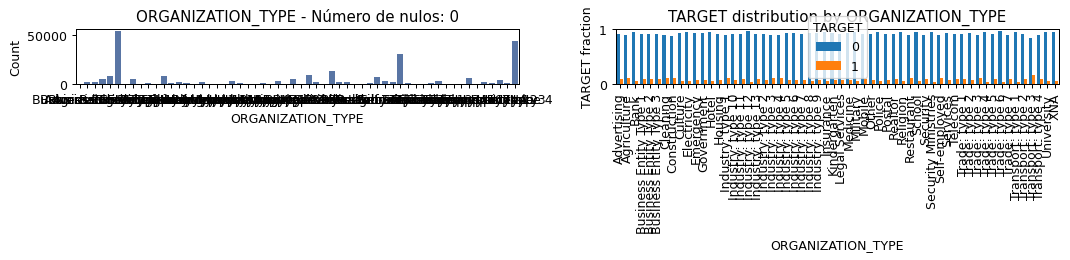

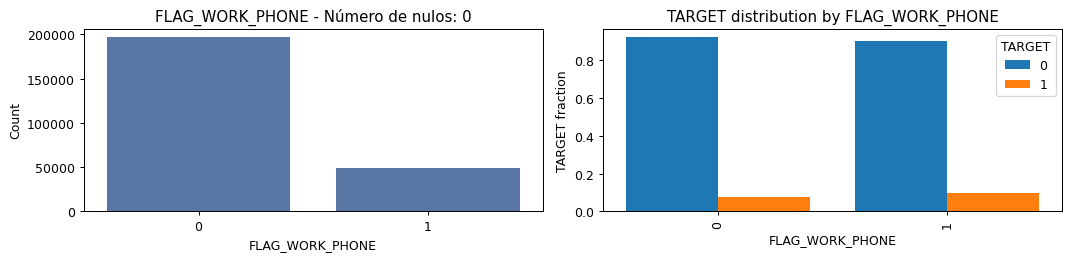

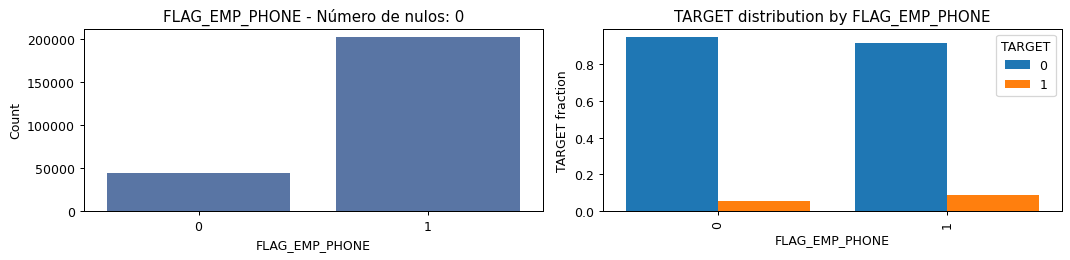

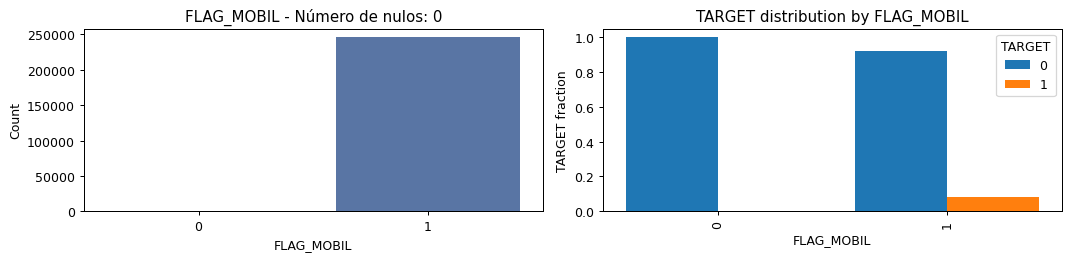

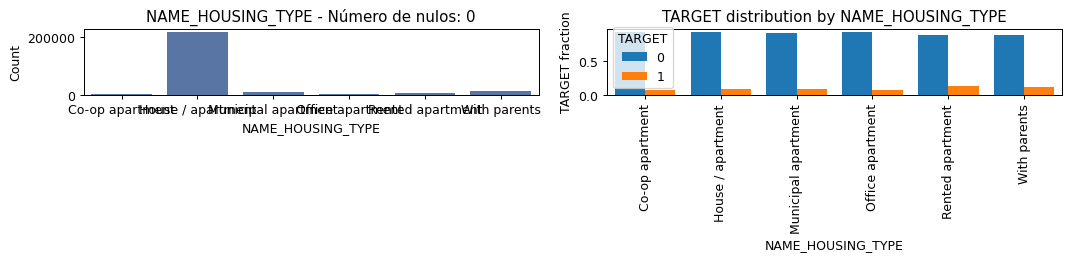

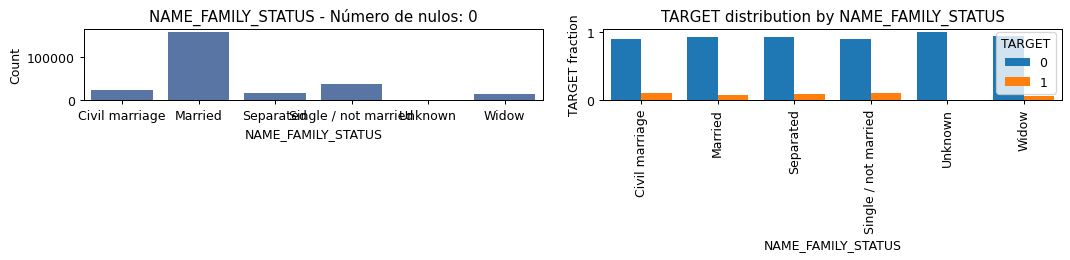

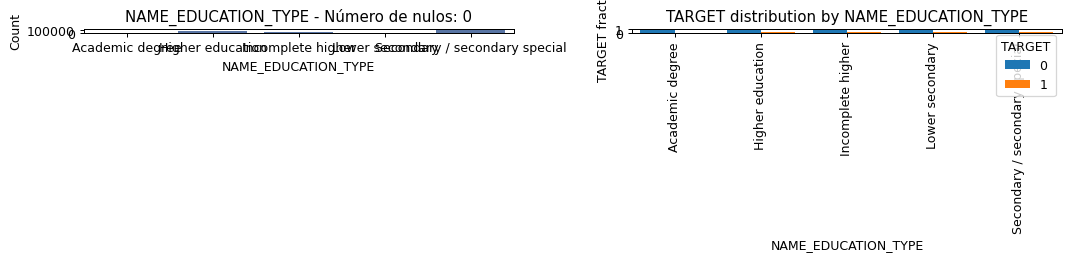

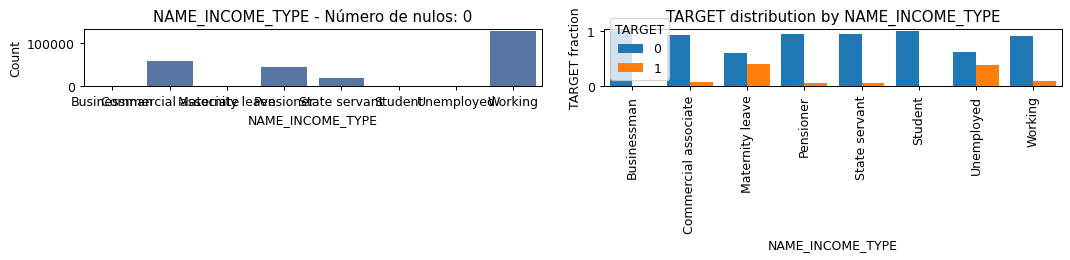

In [ ]:
warnings.filterwarnings('ignore')
for i in list(pd_loan_train.columns):
    # Checks if the column is not continuous and is not 'TARGET'.
    if (pd_loan_train[i].dtype in ['object', 'category']) & (i != 'TARGET'):
        # Call function for categorical variables
        plot_categorical_feature(pd_loan_train, col_name=i, target='TARGET')

En cuanto a los gráficos podemos sacar y siendo que: 
Comentarios de gráficos EDA:
1-	CLIENTE CON DIFICULTADES
0-	CLIENTE SIN DIFICULTADES

--------------VARIABLES CONTINUAS--------------

-VARIABLE: AMT_REQ_CREDIT_BUREAU:
Vemos una diferencia significante entre el número de consultas a la oficina de crédito ('CREDIT_BUREAU') sobre el cliente un día al año (excluidos los 3 últimos meses antes de la solicitud) entre los que han tenido dificultades y los que no. Se puede observar como aquellos que han tenido mayor dificultad para pagar su respectivo crédito son más probables de ser objetivo de consulta a la oficina de crédito

-VARIABLE: DAYS_BIRTH:
En cuanto a la edad, parece ser también un indicativo de dificultades para el pago siendo que los clientes más jóvenes tienen más probabilidad de tener dificultades frente al pago del crédito. Vemos como la mediana de clientes con dificultades es de aproximadamente 38 años mientras que la de clientes que no tuvieron dificultades es mayor a los 43 años.

-VARIABLE: OWN_CAR_AGE:
Esta variable nos indica la edad que tiene el coche del cliente, en este caso vemos como la mediana de edad del coche del cliente para los que tuvieron dificultades de pago es mayor, podriamos decir que tener un coche más antiguo puede ser significante a la hora de tener dificultades con los pagos, esto se puede deber a que los que no han tenido dificultades puedan permitirse coches más nuevos. La mediana para los que no tuvieron dificultades se encuentra aproximadamente en los 9 años de edad mientras que la de los que si tuvieron se aproxima más a 11 años.

-VARIABLES: EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3:
Estas tres variables que aparentemente recojen "una puntuación o score normalizada de una fuente de datos externa" aparentemente la mediana para los que tuvieron dificultades es bastante inferior (casi 0.2 puntos sobre 1 en los 3 casos) por lo que es probable que en tuvieran scores o puntuaciones más bajas en otras fuentes de datos y eso afecte a la variable 'TARGET'.

-VARIABLE: DAYS_LAST_PHONE_CHANGE:
Aparentemente aquellos que cambiaron de móvil más recientemente han tenido más dificultades para realizar los pagos, entrando en suposiciones, esto puede deberse diferentes razones, como se me ocurre que sean inmigrantes de otros países que no tienen tantas oportunidades y que necesiten un nuevo móvil para solicitar el crédito entre otras.

-VARIABLE: DAYS_ID_PUBLISH:
Sucede algo similar a la variable del telefono móvil. Cuanto menos tiempo haya pasado desde la última actualización de su documento de identidad. Puede también estar relacionado con alguien que ha obtenido una nueva visa y busca un crédito para empezar en otro país o similares.

-VARIABLE: DAYS_REGISTRATION:
Pese a que aparentemente la mediana no difiere tanto, se debe a los outliers que alteran la escala del gráfico y las variables van de 5000 en 5000, pero la distancia es similar en proporción a la de anteriores variables. Esta variable recoge hace cuantos días el cliente cambio su registro, aparentemente los que tienen más dificultades lo cambiaron más recientemente.

--------------VARIABLES CATEGÓRICAS--------------

-VARIABLE OCCUPATION_TYPE:
Dentro del trabajo que realizaban los tomadores del crédito observamos como hay algunas profesiones que tienen significantemente más dificultades para realizar el pago, estas son: 
-Low Skills Laborers
-Waiters/barmen staff
-Drivers
En conclusión, los trabajadores con menos cualificación tienen más probabilidad de tener dificultades al realizar los pagos, en cambio los trabajadores más cualificados, en proporción, tienden a tener menos problemas, como observamso en empleos como:
-High Skill Tech Staff
-Accountants
-Medicine Staff

VARIABLE NAME_CONTRACT_TYPE:
El tipo de contrato parece que afecta levemente a las dificultades a la hora de pagar, los “Cash Loans” o créditos tradicionales parecen generar más dificultades, esto podría deberse a la cuota fija mensual y que no siempre los tomadores del crédito lleguen a ella, el carácter mixto del “Revolving Loan” hace que si un mes un cliente vaya más apurado y su gasto sea menor sea más difícil de devolver al ser una cantidad menor.

VARIABLE: FLAG_DOCUMENT_2:
Suponiendo que 0 es entregado y 1 no entregado, podemos ver que dentro de aquellos que no lo entregaron, una gran parte han tenido dificultades para pagar el préstamo por lo que sería interesante pedir antes de aprobar un préstamo este documento ya que aparentemente influye en la capacidad de luego devolver los pagos

VARIABLE: WALLSMATERIAL_MODE:
Esta variable recoge de que estan hechas las paredes de la vivienda del cliente, pareces ser que aquellas viviendas hechas de materiales más frágiles, vease madera o mixtos (intuyendo como mixtos una mezcla de materiales de bajo coste) tiene mayores dificultades a la hora de realizar los pagos.

VARIABLE: NAME_HOUSING_TYPE: 
Esta variable recoge donde o con quien convive el tomador del préstamo, la gran mayoría vive en una casa/apartamento, pero si es verdad que, de los que viven en un apartamento alquilado o con sus padres muestran más dificultad a la hora de realizar los pagos, esto se puede deber a que parte del dinero se va en el alquiler o en el caso de los que viven con sus padres que son estudiantes o no se pueden permitir ni si quiera un alquiler.

VARIABLE: NAME_INCOME_TYPE:
En cuanto a la variable que nos dice de donde provienen sus ingresos, la gran mayoría de sujetos se encuentran trabajando, son asociados, pensionistas o trabajadores del estado, aquellos que parecen tener más dificultad son los desempleados, cosa que se podía preveer, y las bajas de maternidad al ver disminuidos los ingresos percibidos por la baja,


In [22]:
f_aux.get_deviation_of_mean_perc(pd_loan_train, list_var_cont, target='TARGET', multiplier=3)

0.0       1.0                      variable  sum_outlier_values  \
0    0.000000  1.000000               COMMONAREA_MEDI                1371   
1    0.944566  0.055434               COMMONAREA_MEDI                1371   
2    0.000000  1.000000                COMMONAREA_AVG                1359   
3    0.944812  0.055188                COMMONAREA_AVG                1359   
4    0.000000  1.000000               COMMONAREA_MODE                1352   
5    0.943047  0.056953               COMMONAREA_MODE                1352   
6    0.000000  1.000000      NONLIVINGAPARTMENTS_MODE                 533   
7    0.930582  0.069418      NONLIVINGAPARTMENTS_MODE                 533   
8    0.000000  1.000000       NONLIVINGAPARTMENTS_AVG                 567   
9    0.938272  0.061728       NONLIVINGAPARTMENTS_AVG                 567   
10   0.000000  1.000000      NONLIVINGAPARTMENTS_MEDI                 569   
11   0.936731  0.063269      NONLIVINGAPARTMENTS_MEDI                 569   
12   0.000000  1.000000         LIVINGAPARTMENTS_MODE                1441   
13   0.943095  0.056905         LIVINGAPARTMENTS_MODE                1441   
14   0.000000  1.000000          LIVINGAPARTMENTS_AVG                1395   
15   0.946953  0.053047          LIVINGAPARTMENTS_AVG                1395   
16   0.000000  1.000000         LIVINGAPARTMENTS_MEDI                1405   
17   0.945907  0.054093         LIVINGAPARTMENTS_MEDI                1405   
18   0.000000  1.000000                 FLOORSMIN_AVG                 475   
19   0.960000  0.040000                 FLOORSMIN_AVG                 475   
20   0.000000  1.000000                FLOORSMIN_MODE                 388   
21   0.958763  0.041237                FLOORSMIN_MODE                 388   
22   0.000000  1.000000                FLOORSMIN_MEDI                 448   
23   0.959821  0.040179                FLOORSMIN_MEDI                 448   
24   0.000000  1.000000              YEARS_BUILD_MEDI                 959   
25   0.921794  0.078206              YEARS_BUILD_MEDI                 959   
26   0.000000  1.000000              YEARS_BUILD_MODE                 957   
27   0.920585  0.079415              YEARS_BUILD_MODE                 957   
28   0.000000  1.000000               YEARS_BUILD_AVG                 947   
29   0.920803  0.079197               YEARS_BUILD_AVG                 947   
30   0.000000  1.000000                   OWN_CAR_AGE                2686   
31   0.918466  0.081534                   OWN_CAR_AGE                2686   
32   0.000000  1.000000                 LANDAREA_MEDI                1733   
33   0.937680  0.062320                 LANDAREA_MEDI                1733   
34   0.000000  1.000000                 LANDAREA_MODE                1740   
35   0.935057  0.064943                 LANDAREA_MODE                1740   
36   0.000000  1.000000                  LANDAREA_AVG                1713   
37   0.936953  0.063047                  LANDAREA_AVG                1713   
38   0.000000  1.000000             BASEMENTAREA_MEDI                1596   
39   0.949875  0.050125             BASEMENTAREA_MEDI                1596   
40   0.000000  1.000000              BASEMENTAREA_AVG                1575   
41   0.949841  0.050159              BASEMENTAREA_AVG                1575   
42   0.000000  1.000000             BASEMENTAREA_MODE                1648   
43   0.949029  0.050971             BASEMENTAREA_MODE                1648   
44   0.000000  1.000000            NONLIVINGAREA_MODE                1992   
45   0.950301  0.049699            NONLIVINGAREA_MODE                1992   
46   0.000000  1.000000             NONLIVINGAREA_AVG                1965   
47   0.949109  0.050891             NONLIVINGAREA_AVG                1965   
48   0.000000  1.000000            NONLIVINGAREA_MEDI                1974   
49   0.949848  0.050152            NONLIVINGAREA_MEDI                1974   
50   0.000000  1.000000                ELEVATORS_MEDI                1915   
51   0

El código anterior y su respuesta nos devuelve el porcentaje de valores que se encuentran fuera de un intervalo de confianza definido en torno a la media de cada variable continua en list_var_cont, y devuelve un dataframe que describe la proporción de estos valores outliers. Además, examina cómo estos valores se distribuyen en función de una columna de 'TARGET' en el dataframe.
Teoricamente la distribución de las columnas 0 y 1 de la tabla anterior debería seguir la misma distribución que la de train y test (0 = 0.92, 1= 0,08), aquellas variables en las que cambie drasticamente significaría que dicha columna tiene más o menos porcentaje de 0 o de 1. Pongamos por ejemplo la variable 'FLOORSMIN_AVG' donde la los outlier tienen un mayor porcentaje, es decir se encuentran más, en 'no dificultades para el pago' (pasa de 0.92 a 0.96 aprox)	

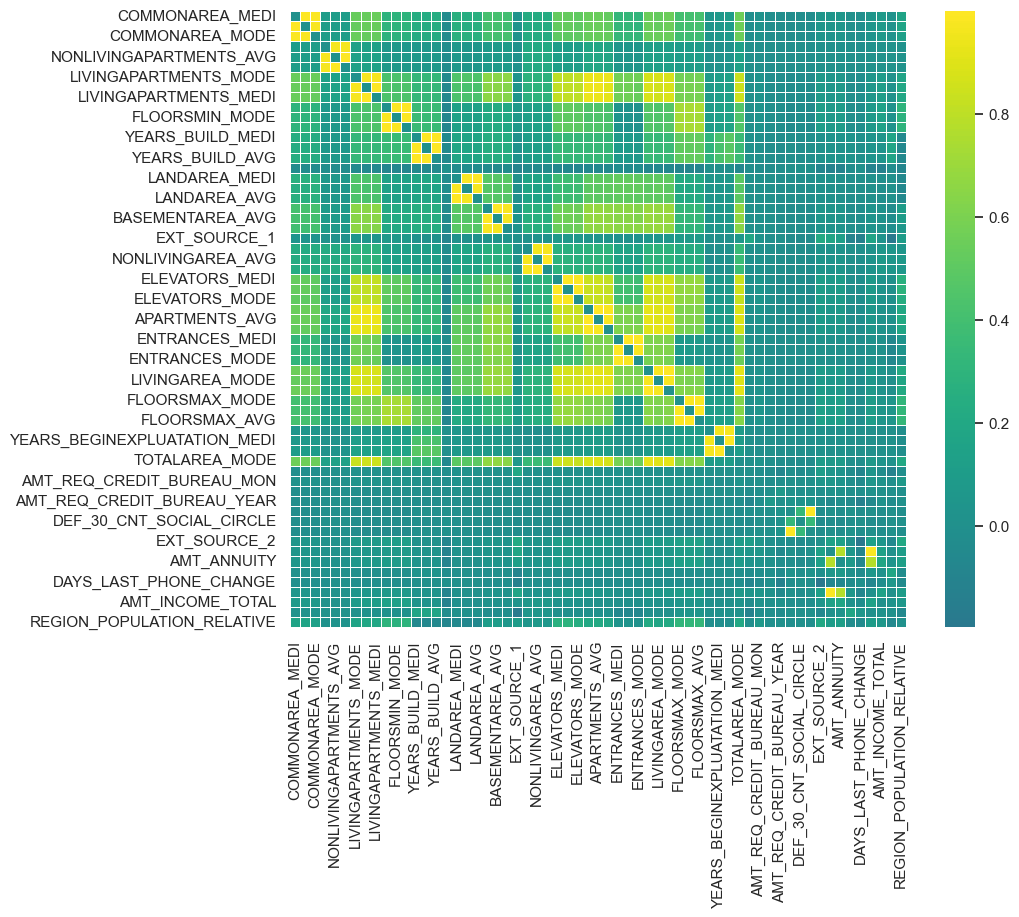

0

In [23]:
f_aux.get_corr_matrix(dataset = pd_loan_train[list_var_cont], 
                metodo='pearson', size_figure=[10,8])

El anterior código nos muestra las correlaciones que existen entre las variables. Al haber tantas variables es muy dificil de analizar e interpretar, no obstante podemos hacerlo a través del siguiente código con el cual podemos ver cuales son las variables con más relación entre sí, se escogen aquellas cuya correlación sea >70% ya que el conjunto de variables (columnas) es muy amplio. Vemos como las principales correlaciones son las mismas variables pero expresadas de otra forma como nos dice el diccionario de variables

In [24]:
corr = pd_loan_train[list_var_cont].corr('pearson')
new_corr = corr.abs()
new_corr.loc[:,:] = np.tril(new_corr, k=-1) # below main lower triangle of an array
new_corr = new_corr.stack().to_frame('correlation').reset_index().sort_values(by='correlation', ascending=False)
new_corr[new_corr['correlation'] > 0.7]


level_0                       level_1  correlation
3160      OBS_60_CNT_SOCIAL_CIRCLE      OBS_30_CNT_SOCIAL_CIRCLE     0.998511
866                YEARS_BUILD_AVG              YEARS_BUILD_MEDI     0.998477
680                 FLOORSMIN_MEDI                 FLOORSMIN_AVG     0.997245
2479                 FLOORSMAX_AVG                FLOORSMAX_MEDI     0.997021
2045                 ENTRANCES_AVG                ENTRANCES_MEDI     0.996918
61                  COMMONAREA_AVG               COMMONAREA_MEDI     0.996382
1673                 ELEVATORS_AVG                ELEVATORS_MEDI     0.996020
2292               LIVINGAREA_MEDI                LIVINGAREA_AVG     0.995843
495          LIVINGAPARTMENTS_MEDI          LIVINGAPARTMENTS_AVG     0.995328
1859                APARTMENTS_AVG               APARTMENTS_MEDI     0.995124
2665   YEARS_BEGINEXPLUATATION_AVG  YEARS_BEGINEXPLUATATION_MEDI     0.993844
1239              BASEMENTAREA_AVG             BASEMENTAREA_MEDI     0.993824
309       NONLIVINGAPARTMENTS_MEDI       NONLIVINGAPARTMENTS_AVG     0.991780
1114                  LANDAREA_AVG                 LANDAREA_MEDI     0.990134
1549            NONLIVINGAREA_MEDI             NONLIVINGAREA_AVG     0.989556
867                YEARS_BUILD_AVG              YEARS_BUILD_MODE     0.989399
805               YEARS_BUILD_MODE              YEARS_BUILD_MEDI     0.989382
681                 FLOORSMIN_MEDI                FLOORSMIN_MODE     0.988760
2417                FLOORSMAX_MEDI                FLOORSMAX_MODE     0.988430
3530                    AMT_CREDIT               AMT_GOODS_PRICE     0.986912
619                 FLOORSMIN_MODE                 FLOORSMIN_AVG     0.986325
2478                 FLOORSMAX_AVG                FLOORSMAX_MODE     0.985861
1734                ELEVATORS_MODE                ELEVATORS_MEDI     0.982601
1053                 LANDAREA_MODE                 LANDAREA_MEDI     0.980747
2106                ENTRANCES_MODE                ENTRANCES_MEDI     0.980217
122                COMMONAREA_MODE               COMMONAREA_MEDI     0.979969
1735                ELEVATORS_MODE                 ELEVATORS_AVG     0.978467
1300             BASEMENTAREA_MODE             BASEMENTAREA_MEDI     0.978067
123                COMMONAREA_MODE                COMMONAREA_AVG     0.977409
2107                ENTRANCES_MODE                 ENTRANCES_AVG     0.977365
1920               APARTMENTS_MODE               APARTMENTS_MEDI     0.976742
308       NONLIVINGAPARTMENTS_MEDI      NONLIVINGAPARTMENTS_MODE     0.974976
2293               LIVINGAREA_MEDI               LIVINGAREA_MODE     0.974665
1548            NONLIVINGAREA_MEDI            NONLIVINGAREA_MODE     0.974584
494          LIVINGAPARTMENTS_MEDI         LIVINGAPARTMENTS_MODE     0.974430
1301             BASEMENTAREA_MODE              BASEMENTAREA_AVG     0.973156
1921               APARTMENTS_MODE                APARTMENTS_AVG     0.972762
2664   YEARS_BEGINEXPLUATATION_AVG  YEARS_BEGINEXPLUATATION_MODE     0.972237
2231               LIVINGAREA_MODE                LIVINGAREA_AVG     0.972191
1115                  LANDAREA_AVG                 LANDAREA_MODE     0.971778
433           LIVINGAPARTMENTS_AVG         LIVINGAPARTMENTS_MODE     0.970417
247        NONLIVINGAPARTMENTS_AVG      NONLIVINGAPARTMENTS_MODE     0.966745
1487             NONLIVINGAREA_AVG            NONLIVINGAREA_MODE     0.963975
2603  YEARS_BEGINEXPLUATATION_MEDI  YEARS_BEGINEXPLUATATION_MODE     0.962688
1837                APARTMENTS_AVG          LIVINGAPARTMENTS_AVG     0.943765
1838                APARTMENTS_AVG         LIVINGAPARTMENTS_MEDI     0.941273
1777               APARTMENTS_MEDI         LIVINGAPARTMENTS_MEDI     0.941149
1897               APARTMENTS_MODE         LIVINGAPARTMENTS_MODE     0.936658
1776               APARTMENTS_MEDI          LIVINGAPARTMENTS_AVG     0.935679
1775               APARTMENTS_MEDI         LIVINGAPARTMENTS_MODE     0.931484
1836                APARTMENTS_AVG         LIVING

Vemos como las correlaciones suelen encontrarse en las mismas variables expuestas de diferentes forma como puede ser OBS_60_CNT_SOCIAL_CIRCLE y OBS_30_CNT_SOCIAL_CIRCLE siendo que estas observan cuántas observaciones del entorno social del cliente con morosidad se observaron 60 y 30 días de retraso, es decir, es posible que aquellas variables con nombre similar y correlacionadas expliquen lo mismo con diferente magnitud (más o menos días, promedio o mediana...)

Comprobamos que existen valores nulos para las variables continuas

In [25]:
f_aux.get_percent_null_values_target(pd_loan_train, list_var_cont, target='TARGET')

0.0       1.0                      variable  sum_null_values  \
0    0.000000  1.000000               COMMONAREA_MEDI           171972   
1    0.914387  0.085613               COMMONAREA_MEDI           171972   
2    0.000000  1.000000                COMMONAREA_AVG           171972   
3    0.914387  0.085613                COMMONAREA_AVG           171972   
4    0.000000  1.000000               COMMONAREA_MODE           171972   
5    0.914387  0.085613               COMMONAREA_MODE           171972   
6    0.000000  1.000000      NONLIVINGAPARTMENTS_MODE           170909   
7    0.914270  0.085730      NONLIVINGAPARTMENTS_MODE           170909   
8    0.000000  1.000000       NONLIVINGAPARTMENTS_AVG           170909   
9    0.914270  0.085730       NONLIVINGAPARTMENTS_AVG           170909   
10   0.000000  1.000000      NONLIVINGAPARTMENTS_MEDI           170909   
11   0.914270  0.085730      NONLIVINGAPARTMENTS_MEDI           170909   
12   0.000000  1.000000         LIVINGAPARTMENTS_MODE           168277   
13   0.913850  0.086150         LIVINGAPARTMENTS_MODE           168277   
14   0.000000  1.000000          LIVINGAPARTMENTS_AVG           168277   
15   0.913850  0.086150          LIVINGAPARTMENTS_AVG           168277   
16   0.000000  1.000000         LIVINGAPARTMENTS_MEDI           168277   
17   0.913850  0.086150         LIVINGAPARTMENTS_MEDI           168277   
18   0.000000  1.000000                 FLOORSMIN_AVG           166993   
19   0.913829  0.086171                 FLOORSMIN_AVG           166993   
20   0.000000  1.000000                FLOORSMIN_MODE           166993   
21   0.913829  0.086171                FLOORSMIN_MODE           166993   
22   0.000000  1.000000                FLOORSMIN_MEDI           166993   
23   0.913829  0.086171                FLOORSMIN_MEDI           166993   
24   0.000000  1.000000              YEARS_BUILD_MEDI           163682   
25   0.913320  0.086680              YEARS_BUILD_MEDI           163682   
26   0.000000  1.000000              YEARS_BUILD_MODE           163682   
27   0.913320  0.086680              YEARS_BUILD_MODE           163682   
28   0.000000  1.000000               YEARS_BUILD_AVG           163682   
29   0.913320  0.086680               YEARS_BUILD_AVG           163682   
30   0.000000  1.000000                   OWN_CAR_AGE           162223   
31   0.914716  0.085284                   OWN_CAR_AGE           162223   
32   0.000000  1.000000                 LANDAREA_MEDI           146053   
33   0.912059  0.087941                 LANDAREA_MEDI           146053   
34   0.000000  1.000000                 LANDAREA_MODE           146053   
35   0.912059  0.087941                 LANDAREA_MODE           146053   
36   0.000000  1.000000                  LANDAREA_AVG           146053   
37   0.912059  0.087941                  LANDAREA_AVG           146053   
38   0.000000  1.000000             BASEMENTAREA_MEDI           143994   
39   0.911114  0.088886             BASEMENTAREA_MEDI           143994   
40   0.000000  1.000000              BASEMENTAREA_AVG           143994   
41   0.911114  0.088886              BASEMENTAREA_AVG           143994   
42   0.000000  1.000000             BASEMENTAREA_MODE           143994   
43   0.911114  0.088886             BASEMENTAREA_MODE           143994   
44   0.000000  1.000000                  EXT_SOURCE_1           138885   
45   0.914764  0.085236                  EXT_SOURCE_1           138885   
46   0.000000  1.000000            NONLIVINGAREA_MODE           135759   
47   0.909840  0.090160            NONLIVINGAREA_MODE           135759   
48   0.000000  1.000000             NONLIVINGAREA_AVG           135759   
49   0.909840  0.090160             NONLIVINGAREA_AVG           135759   
50   0.000000  1.000000            NONLIVINGAREA_MEDI           135759   
51   0.909840  0.090160            NONLIVINGAREA_MEDI           135759   
52   0.000000  1.000000                ELEVATORS_MEDI           131138   
53   0.909271 

Vamos a cambiar los valores nulos de las columnas continuas por la mediana de los valores no nulos de la columna, se ha elegido la mediana ya que a diferencia de la media (promedio), la mediana no se ve afectada por valores atípicos o extremos en los datos. Al tener un dataset con variables con valores muy extremos (como se puede observar en los gráficos) la mediana es una mejor medida de tendencia central porque representa el punto medio de la distribución.

In [ ]:
train_median = pd_loan_train[list_var_cont].median()
pd_loan_train[list_var_cont] = pd_loan_train[list_var_cont].fillna(train_median)
pd_loan_test[list_var_cont] = pd_loan_test[list_var_cont].fillna(train_median)

Comprobamos que no existen valores nulos tras la transformación ya que estos han sido sustituidos por la mediana de la variable.

In [27]:
f_aux.get_percent_null_values_target(pd_loan_train, list_var_cont, target='TARGET')

No existen variables con valores nulos


Empty DataFrame
Columns: []
Index: []

Tratamiento de variables CATEGÓRICAS

In [28]:
list_var_cat

['FONDKAPREMONT_MODE',
 'WALLSMATERIAL_MODE',
 'HOUSETYPE_MODE',
 'EMERGENCYSTATE_MODE',
 'OCCUPATION_TYPE',
 'NAME_TYPE_SUITE',
 'CNT_CHILDREN',
 'FLAG_DOCUMENT_8',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_21',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_OWN_REALTY',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_18',
 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_20',
 'FLAG_DOCUMENT_12',
 'FLAG_PHONE',
 'LIVE_CITY_NOT_WORK_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'TARGET',
 'REG_CITY_NOT_LIVE_CITY',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'REG_REGION_NOT_LIVE_REGION',
 'HOUR_APPR_PROCESS_START',
 'WEEKDAY_APPR_PROCESS_START',
 'REGION_RATING_CLIENT_W_CITY',
 'REGION_RATING_CLIENT',
 'FLAG_EMAIL',
 'FLAG_CONT_MOBILE',
 'ORGANIZATI

Ahora se va a ver si existe correlación entre algunas de las variables categóricas que puedan ser importantes para el análisis de la dificultad frente a los pagos. He creado un bucle adicional que me devuelva cada valor de la V de Cramer para cada variable categórica y que se ordene de mayor relación a menor.

In [ ]:
def cramers_v(matrix):
    chi2, p, dof, ex = chi2_contingency(matrix)  # Chi-squared test
    return np.sqrt(chi2 / (matrix.sum().sum() * (min(matrix.shape) - 1)))

cramers_v_results = {}

for col in list_var_cat:
    # We calculate the confusion matrix between the categorical variable and TARGET.
    confusion_matrix = pd.crosstab(pd_loan_train["TARGET"], pd_loan_train[col])
    
    # We calculate the Cramér's V for this matrix
    cramers_v_value = cramers_v(confusion_matrix.values)
    
    # We save the result in the dictionary
    cramers_v_results[col] = cramers_v_value

cramers_v_df = pd.DataFrame(list(cramers_v_results.items()), columns=['Variable', 'Cramér\'s V'])
cramers_v_df = cramers_v_df.sort_values(by='Cramér\'s V', ascending=False)

print(cramers_v_df)

                       Variable  Cramér's V
34                       TARGET    0.999973
4               OCCUPATION_TYPE    0.080065
45            ORGANIZATION_TYPE    0.074128
52             NAME_INCOME_TYPE    0.064792
41  REGION_RATING_CLIENT_W_CITY    0.061046
42         REGION_RATING_CLIENT    0.059173
51          NAME_EDUCATION_TYPE    0.056335
9                   CODE_GENDER    0.055191
33       REG_CITY_NOT_WORK_CITY    0.050677
47               FLAG_EMP_PHONE    0.046979
12              FLAG_DOCUMENT_3    0.044897
35       REG_CITY_NOT_LIVE_CITY    0.043686
50           NAME_FAMILY_STATUS    0.039488
49            NAME_HOUSING_TYPE    0.036335
32      LIVE_CITY_NOT_WORK_CITY    0.032358
8            NAME_CONTRACT_TYPE    0.031104
39      HOUR_APPR_PROCESS_START    0.029447
15              FLAG_DOCUMENT_6    0.029307
46              FLAG_WORK_PHONE    0.028350
1            WALLSMATERIAL_MODE    0.027483
6                  CNT_CHILDREN    0.023839
31                   FLAG_PHONE 

Observamos como las variables categóricas, salvo la propia 'TARGET', tienen todas un valor de la V de Cramers muy bajo , todas ellas inferiores a 0.1, esto significa que las variables categóricas tienen una asociación muy débil con la variable 'TARGET'. Dado que las variables categóricas no muestran una correlación fuerte con 'TARGET', podríamos considerar reducir su peso en el modelo o explorar otras características que podrían tener una mayor influencia. Esto indica que es posible que la variable TARGET dependa más de variables numéricas o continuas que de las variables categóricas. Por lo que sería interesante investigar la correlación de TARGET con las variables continuas y explorar la importancia de estas características para predecir TARGET."

In [ ]:
pd_loan_train[list_var_cat] = pd_loan_train[list_var_cat].astype("object").fillna("VALUELESS").astype("category")
pd_loan_test[list_var_cat] = pd_loan_test[list_var_cat].astype("object").fillna("VALUELESS").astype("category")

In [31]:
pd_loan_train['AMT_REQ_CREDIT_BUREAU_DAY'] = pd_loan_train['AMT_REQ_CREDIT_BUREAU_DAY'].fillna(0)
pd_loan_train['AMT_REQ_CREDIT_BUREAU_WEEK'] = pd_loan_train['AMT_REQ_CREDIT_BUREAU_WEEK'].fillna(0)
pd_loan_train['AMT_REQ_CREDIT_BUREAU_HOUR'] = pd_loan_train['AMT_REQ_CREDIT_BUREAU_HOUR'].fillna(0)
pd_loan_train['DEF_60_CNT_SOCIAL_CIRCLE'] = pd_loan_train['DEF_60_CNT_SOCIAL_CIRCLE'].fillna(0)
pd_loan_test['AMT_REQ_CREDIT_BUREAU_DAY'] = pd_loan_test['AMT_REQ_CREDIT_BUREAU_DAY'].fillna(0)
pd_loan_test['AMT_REQ_CREDIT_BUREAU_WEEK'] = pd_loan_test['AMT_REQ_CREDIT_BUREAU_WEEK'].fillna(0)
pd_loan_test['AMT_REQ_CREDIT_BUREAU_HOUR'] = pd_loan_test['AMT_REQ_CREDIT_BUREAU_HOUR'].fillna(0)
pd_loan_test['DEF_60_CNT_SOCIAL_CIRCLE'] = pd_loan_test['DEF_60_CNT_SOCIAL_CIRCLE'].fillna(0)

In [32]:
pd_loan_train.isna().sum().sum()

0

A través del código anterior lo que se hace es transformar las columnas categóricas a objecto, un formato de variable más 'flexible', rellena los NaN con la cade de texto 'SIN VALOR' y despues las vuelve a transformar a category.

In [33]:
pd_loan_train.to_csv("../data/train_pd_data_preprocessing_missing_outlier.csv")
pd_loan_test.to_csv("../data/test_pd_data_preprocessing_missing_outlier.csv")

Volvemos a guardar los datasets de train y test que hemos utilizado y manipulado en formato .csv para seguir podiendo utilizarlos en el siguiente notebook